In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import math
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Activation, Reshape

#Load and Prepare Data

In [110]:
# load the data for each subset
def load_dataframe(subset_number):
    directory = 'C-MAPSS/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    train_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/train_FD00{subset_number}.txt"
    os.system(f"wget -q {train_url} -O {directory}train_FD00{subset_number}.txt")
    turbo_train = pd.read_csv(f"{directory}train_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    test_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/test_FD00{subset_number}.txt"
    os.system(f"wget -q {test_url} -O {directory}test_FD00{subset_number}.txt")
    turbo_test = pd.read_csv(f"{directory}test_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    rul_url = f"https://raw.githubusercontent.com/DemetraAS/C-MAPSS/main/RUL_FD00{subset_number}.txt"
    os.system(f"wget -q {rul_url} -O {directory}RUL_FD00{subset_number}.txt")
    y_RUL = pd.read_csv(f"{directory}RUL_FD00{subset_number}.txt", sep='\s+', header=None, index_col=False)

    return turbo_train, turbo_test, y_RUL

In [111]:
turbo_train_1, turbo_test_1, y_RUL_1 = load_dataframe(1)
turbo_train_2, turbo_test_2, y_RUL_2 = load_dataframe(2)
turbo_train_3, turbo_test_3, y_RUL_3 = load_dataframe(3)
turbo_train_4, turbo_test_4, y_RUL_4 = load_dataframe(4)

In [112]:
turbo_train_1

0    1       2       3      4       5       6        7        8   \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
20626  100  196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63   
20627  100  197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58   
20628  100  198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18   
20629  100  199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53   
20630  100  200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14   

          9   ...      16       17       18      19    20   21    22     23  \
0      14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1      14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2      14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3      14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4      14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
...      ...  ...     ...      ...      ...     ...   ...  ...   ...    ...   
20626  14.62  ...  519.49  2388.26  8137.60  8.4956  0.03  397  2388  100.0   
20627  14.62  ...  519.68  2388.22  8136.50  8.5139  0.03  395  2388  100.0   
20628  14.62  ...  520.01  2388.24  8141.05  8.5646  0.03  398  2388  100.0   
20629  14.62  ...  519.67  2388.23  8139.29  8.5389  0.03  395  2388  100.0   
20630  14.62  ...  519.30  2388.26  8137.33  8.5036  0.03  396  2388  100.0   

          24       25  
0      39.06  23.4190  
1      39.00  23.4236  
2      38.95  23.3442  
3      38.88  23.3739  
4      38.90  23.4044  
...      ...      ...  
20626  38.49  22.9735  
20627  38.30  23.1594  
20628  38.44  22.9333  
20629  38.29  23.0640  
20630  38.37  23.0522  

[20631 rows x 26 columns]

In [113]:
#count the number of engines for each subset (useful for subsequent functions)
def count_engines(turbofan):
  unique_engines = turbofan[0].unique()
  num_engines = len(unique_engines)
  return num_engines

In [114]:
nr_train_1=count_engines(turbo_train_1)
nr_train_2=count_engines(turbo_train_2)
nr_train_3=count_engines(turbo_train_3)
nr_train_4=count_engines(turbo_train_4)
nr_test_1=count_engines(turbo_test_1)
nr_test_2=count_engines(turbo_test_2)
nr_test_3=count_engines(turbo_test_3)
nr_test_4=count_engines(turbo_test_4)

In [115]:
nr_train_1

100

In [116]:
# assign the original RUL to the training set (here RUL decreases linearly)
def original_RUL_train(turbo_train):
  turbo_train.sort_values(by=[0, 1], inplace=True)
  turbo_train['RUL'] = turbo_train.groupby(0).cumcount(ascending=False)
  return turbo_train

In [117]:
turbo_train_1=original_RUL_train(turbo_train_1)
turbo_train_2=original_RUL_train(turbo_train_2)
turbo_train_3=original_RUL_train(turbo_train_3)
turbo_train_4=original_RUL_train(turbo_train_4)

In [118]:
turbo_train_1

0    1       2       3      4       5       6        7        8  \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
20626  100  196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63   
20627  100  197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58   
20628  100  198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18   
20629  100  199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53   
20630  100  200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14   

           9  ...       17       18      19    20   21    22     23     24  \
0      14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1      14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2      14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3      14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4      14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   
...      ...  ...      ...      ...     ...   ...  ...   ...    ...    ...   
20626  14.62  ...  2388.26  8137.60  8.4956  0.03  397  2388  100.0  38.49   
20627  14.62  ...  2388.22  8136.50  8.5139  0.03  395  2388  100.0  38.30   
20628  14.62  ...  2388.24  8141.05  8.5646  0.03  398  2388  100.0  38.44   
20629  14.62  ...  2388.23  8139.29  8.5389  0.03  395  2388  100.0  38.29   
20630  14.62  ...  2388.26  8137.33  8.5036  0.03  396  2388  100.0  38.37   

            25  RUL  
0      23.4190  191  
1      23.4236  190  
2      23.3442  189  
3      23.3739  188  
4      23.4044  187  
...        ...  ...  
20626  22.9735    4  
20627  23.1594    3  
20628  22.9333    2  
20629  23.0640    1  
20630  23.0522    0  

[20631 rows x 27 columns]

In [119]:
 # assign the original RUL to the testing set (RUL decreases linearly)
def original_RUL_test(turbo_test, y_RUL):
  y_RUL_series=y_RUL[0]
  turbo_test.sort_values(by=[0, 1], inplace=True)
  adjusted_engine_numbers = turbo_test[0].values - 1
  turbo_test['RUL'] = turbo_test.groupby(0).cumcount(ascending=False) + y_RUL_series.iloc[adjusted_engine_numbers].values
  return turbo_test

In [120]:
turbo_test_1=original_RUL_test(turbo_test_1, y_RUL_1)
turbo_test_2=original_RUL_test(turbo_test_2, y_RUL_2)
turbo_test_3=original_RUL_test(turbo_test_3, y_RUL_3)
turbo_test_4=original_RUL_test(turbo_test_4, y_RUL_4)

In [121]:
turbo_test_1

0    1       2       3      4       5       6        7        8  \
0        1    1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21   
1        1    2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42   
2        1    3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34   
3        1    4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42   
4        1    5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
13091  100  194  0.0049  0.0000  100.0  518.67  643.24  1599.45  1415.79   
13092  100  195 -0.0011 -0.0001  100.0  518.67  643.22  1595.69  1422.05   
13093  100  196 -0.0006 -0.0003  100.0  518.67  643.44  1593.15  1406.82   
13094  100  197 -0.0038  0.0001  100.0  518.67  643.26  1594.99  1419.36   
13095  100  198  0.0013  0.0003  100.0  518.67  642.95  1601.62  1424.99   

           9  ...       17       18      19    20   21    22     23     24  \
0      14.62  ...  2388.03  8125.55  8.4052  0.03  392  2388  100.0  38.86   
1      14.62  ...  2388.06  8139.62  8.3803  0.03  393  2388  100.0  39.02   
2      14.62  ...  2388.03  8130.10  8.4441  0.03  393  2388  100.0  39.08   
3      14.62  ...  2388.05  8132.90  8.3917  0.03  391  2388  100.0  39.00   
4      14.62  ...  2388.03  8129.54  8.4031  0.03  390  2388  100.0  38.99   
...      ...  ...      ...      ...     ...   ...  ...   ...    ...    ...   
13091  14.62  ...  2388.00  8213.28  8.4715  0.03  394  2388  100.0  38.65   
13092  14.62  ...  2388.09  8210.85  8.4512  0.03  395  2388  100.0  38.57   
13093  14.62  ...  2388.04  8217.24  8.4569  0.03  395  2388  100.0  38.62   
13094  14.62  ...  2388.08  8220.48  8.4711  0.03  395  2388  100.0  38.66   
13095  14.62  ...  2388.05  8214.64  8.4903  0.03  396  2388  100.0  38.70   

            25  RUL  
0      23.3735  142  
1      23.3916  141  
2      23.4166  140  
3      23.3737  139  
4      23.4130  138  
...        ...  ...  
13091  23.1974   24  
13092  23.2771   23  
13093  23.2051   22  
13094  23.2699   21  
13095  23.1855   20  

[13096 rows x 27 columns]

In [122]:
#concatenate training and testing set for subsequent operations (reset engines indexes for training set)
def complete_dataframe(turbo_train, turbo_test):
  turbo_test_reset = turbo_test.reset_index(drop=True)
  last_engine = turbo_train[0].iloc[-1]
  turbo_test_reset[0] += last_engine
  turbofan = pd.concat([turbo_train, turbo_test_reset], ignore_index=True)
  return turbofan

In [123]:
turbofan1=complete_dataframe(turbo_train_1, turbo_test_1)
turbofan2=complete_dataframe(turbo_train_2, turbo_test_2)
turbofan3=complete_dataframe(turbo_train_3, turbo_test_3)
turbofan4=complete_dataframe(turbo_train_4, turbo_test_4)

In [124]:
turbofan1

0    1       2       3      4       5       6        7        8  \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
33722  200  194  0.0049  0.0000  100.0  518.67  643.24  1599.45  1415.79   
33723  200  195 -0.0011 -0.0001  100.0  518.67  643.22  1595.69  1422.05   
33724  200  196 -0.0006 -0.0003  100.0  518.67  643.44  1593.15  1406.82   
33725  200  197 -0.0038  0.0001  100.0  518.67  643.26  1594.99  1419.36   
33726  200  198  0.0013  0.0003  100.0  518.67  642.95  1601.62  1424.99   

           9  ...       17       18      19    20   21    22     23     24  \
0      14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1      14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2      14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3      14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4      14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   
...      ...  ...      ...      ...     ...   ...  ...   ...    ...    ...   
33722  14.62  ...  2388.00  8213.28  8.4715  0.03  394  2388  100.0  38.65   
33723  14.62  ...  2388.09  8210.85  8.4512  0.03  395  2388  100.0  38.57   
33724  14.62  ...  2388.04  8217.24  8.4569  0.03  395  2388  100.0  38.62   
33725  14.62  ...  2388.08  8220.48  8.4711  0.03  395  2388  100.0  38.66   
33726  14.62  ...  2388.05  8214.64  8.4903  0.03  396  2388  100.0  38.70   

            25  RUL  
0      23.4190  191  
1      23.4236  190  
2      23.3442  189  
3      23.3739  188  
4      23.4044  187  
...        ...  ...  
33722  23.1974   24  
33723  23.2771   23  
33724  23.2051   22  
33725  23.2699   21  
33726  23.1855   20  

[33727 rows x 27 columns]

In [125]:
# rename columns as in the original paper
def rename_columns(turbofan):
  new_columns = ['ENr', 'C', 'OP-1', 'OP-2', 'OP-3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi',
                 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf-dmd', 'PCNfR-dmd', 'W31', 'W32', 'RUL']
  turbofan.columns = new_columns
  return turbofan

In [126]:
turbofan1=rename_columns(turbofan1)
turbofan2=rename_columns(turbofan2)
turbofan3=rename_columns(turbofan3)
turbofan4=rename_columns(turbofan4)

In [127]:
turbofan1

ENr    C    OP-1    OP-2   OP-3      T2     T24      T30      T50  \
0        1    1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1    2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1    3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1    4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1    5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...  ...     ...     ...    ...     ...     ...      ...      ...   
33722  200  194  0.0049  0.0000  100.0  518.67  643.24  1599.45  1415.79   
33723  200  195 -0.0011 -0.0001  100.0  518.67  643.22  1595.69  1422.05   
33724  200  196 -0.0006 -0.0003  100.0  518.67  643.44  1593.15  1406.82   
33725  200  197 -0.0038  0.0001  100.0  518.67  643.26  1594.99  1419.36   
33726  200  198  0.0013  0.0003  100.0  518.67  642.95  1601.62  1424.99   

          P2  ...      NRf      NRc     BPR  farB  htBleed  Nf-dmd  PCNfR-dmd  \
0      14.62  ...  2388.02  8138.62  8.4195  0.03      392    2388      100.0   
1      14.62  ...  2388.07  8131.49  8.4318  0.03      392    2388      100.0   
2      14.62  ...  2388.03  8133.23  8.4178  0.03      390    2388      100.0   
3      14.62  ...  2388.08  8133.83  8.3682  0.03      392    2388      100.0   
4      14.62  ...  2388.04  8133.80  8.4294  0.03      393    2388      100.0   
...      ...  ...      ...      ...     ...   ...      ...     ...        ...   
33722  14.62  ...  2388.00  8213.28  8.4715  0.03      394    2388      100.0   
33723  14.62  ...  2388.09  8210.85  8.4512  0.03      395    2388      100.0   
33724  14.62  ...  2388.04  8217.24  8.4569  0.03      395    2388      100.0   
33725  14.62  ...  2388.08  8220.48  8.4711  0.03      395    2388      100.0   
33726  14.62  ...  2388.05  8214.64  8.4903  0.03      396    2388      100.0   

         W31      W32  RUL  
0      39.06  23.4190  191  
1      39.00  23.4236  190  
2      38.95  23.3442  189  
3      38.88  23.3739  188  
4      38.90  23.4044  187  
...      ...      ...  ...  
33722  38.65  23.1974   24  
33723  38.57  23.2771   23  
33724  38.62  23.2051   22  
33725  38.66  23.2699   21  
33726  38.70  23.1855   20  

[33727 rows x 27 columns]

#Exploratory Data Analysis (EDA)

##Univariate

In [128]:
# check data type and null values
def get_info(turbofan):
   return turbofan.info()

In [129]:
info1=get_info(turbofan1)
info2=get_info(turbofan2)
info3=get_info(turbofan3)
info4=get_info(turbofan4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33727 entries, 0 to 33726
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ENr        33727 non-null  int64  
 1   C          33727 non-null  int64  
 2   OP-1       33727 non-null  float64
 3   OP-2       33727 non-null  float64
 4   OP-3       33727 non-null  float64
 5   T2         33727 non-null  float64
 6   T24        33727 non-null  float64
 7   T30        33727 non-null  float64
 8   T50        33727 non-null  float64
 9   P2         33727 non-null  float64
 10  P15        33727 non-null  float64
 11  P30        33727 non-null  float64
 12  Nf         33727 non-null  float64
 13  Nc         33727 non-null  float64
 14  epr        33727 non-null  float64
 15  Ps30       33727 non-null  float64
 16  phi        33727 non-null  float64
 17  NRf        33727 non-null  float64
 18  NRc        33727 non-null  float64
 19  BPR        33727 non-null  float64
 20  farB  

In [130]:
#check missing values
def check_missing(turbofan):
   return turbofan.isnull().sum()

In [131]:
missing1=check_missing(turbofan1)
missing2=check_missing(turbofan2)
missing3=check_missing(turbofan3)
missing4=check_missing(turbofan4)

In [132]:
missing1

ENr          0
C            0
OP-1         0
OP-2         0
OP-3         0
T2           0
T24          0
T30          0
T50          0
P2           0
P15          0
P30          0
Nf           0
Nc           0
epr          0
Ps30         0
phi          0
NRf          0
NRc          0
BPR          0
farB         0
htBleed      0
Nf-dmd       0
PCNfR-dmd    0
W31          0
W32          0
RUL          0
dtype: int64

In [133]:
#check number of unique values
def unique_values(turbofan):
   return turbofan.nunique()

In [134]:
unique1=unique_values(turbofan1)
unique2=unique_values(turbofan2)
unique3=unique_values(turbofan3)
unique4=unique_values(turbofan4)

In [135]:
unique1

ENr           200
C             362
OP-1          164
OP-2           14
OP-3            1
T2              1
T24           315
T30          3156
T50          4206
P2              1
P15             2
P30           523
Nf             54
Nc           6882
epr             1
Ps30          162
phi           436
NRf            56
NRc          6457
BPR          1975
farB            1
htBleed        13
Nf-dmd          1
PCNfR-dmd       1
W31           123
W32          5014
RUL           362
dtype: int64

NOTE: Here we can see the columns with constant columns and the attributes dependent on the number of conditions

In [136]:
# compute mean, standard deviation, min, max, quantiles, skewness and kurtosis
def statistics(turbofan):
  description=turbofan.describe()
  skewness = turbofan.apply(skew)
  kurt = turbofan.apply(kurtosis)
  statistics = turbofan.describe()
  statistics.loc['skewness'] = skewness
  statistics.loc['kurtosis'] = kurt
  return statistics

In [137]:
stat1=statistics(turbofan1)
stat2=statistics(turbofan2)
stat3=statistics(turbofan3)
stat4=statistics(turbofan4)

/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.f(v)


NOTE: The warning is generated when calculating skewness and kurtosis for the constant attributes (because division is made with 0)

In [138]:
stat1

ENr             C          OP-1          OP-2     OP-3  \
count     33727.000000  33727.000000  33727.000000  33727.000000  33727.0   
mean         90.350491     96.393572     -0.000010      0.000003    100.0   
std          56.659857     65.100528      0.002193      0.000293      0.0   
min           1.000000      1.000000     -0.008700     -0.000600    100.0   
25%          43.000000     43.000000     -0.001500     -0.000200    100.0   
50%          83.000000     88.000000      0.000000      0.000000    100.0   
75%         137.000000    140.000000      0.001500      0.000300    100.0   
max         200.000000    362.000000      0.008700      0.000700    100.0   
skewness      0.265306      0.667458     -0.015933      0.011955      NaN   
kurtosis     -1.062898      0.067624     -0.002288     -1.130819      NaN   

                T2           T24           T30           T50            P2  \
count     33727.00  33727.000000  33727.000000  33727.000000  3.372700e+04   
mean        518.67    642.601005   1589.581927   1407.303559  1.462000e+01   
std           0.00      0.474789      5.840324      8.432656  3.552766e-15   
min         518.67    641.130000   1569.040000   1382.250000  1.462000e+01   
25%         518.67    642.270000   1585.530000   1401.230000  1.462000e+01   
50%         518.67    642.560000   1589.210000   1406.450000  1.462000e+01   
75%         518.67    642.890000   1593.160000   1412.240000  1.462000e+01   
max         518.67    644.530000   1616.910000   1441.490000  1.462000e+01   
skewness       NaN      0.396865      0.362297      0.570333           NaN   
kurtosis       NaN      0.112000      0.193295      0.206702           NaN   

          ...           NRf           NRc           BPR          farB  \
count     ...  33727.000000  33727.000000  33727.000000  3.372700e+04   
mean      ...   2388.086395   8141.887005      8.435816  3.000000e-02   
std       ...      0.067620     16.382482      0.035360  1.387799e-17   
min       ...   2387.880000   8099.940000      8.324900  3.000000e-02   
25%       ...   2388.040000   8132.780000      8.411000  3.000000e-02   
50%       ...   2388.080000   8139.620000      8.432400  3.000000e-02   
75%       ...   2388.130000   8146.600000      8.457000  3.000000e-02   
max       ...   2388.560000   8293.720000      8.584800  3.000000e-02   
skewness  ...      0.522127      2.619111      0.483587           NaN   
kurtosis  ...      0.542045     11.915216      0.174608           NaN   

               htBleed   Nf-dmd  PCNfR-dmd           W31           W32  \
count     33727.000000  33727.0    33727.0  33727.000000  33727.000000   
mean        392.962523   2388.0      100.0     38.845871     23.307581   
std           1.468023      0.0        0.0      0.170757      0.102073   
min         388.000000   2388.0      100.0     38.140000     22.894200   
25%         392.000000   2388.0      100.0     38.740000     23.245900   
50%         393.000000   2388.0      100.0     38.860000     23.316600   
75%         394.000000   2388.0      100.0     38.970000     23.379200   
max         400.000000   2388.0      100.0     39.430000     23.641900   
skewness      0.425383      NaN        NaN     -0.444441     -0.447665   
kurtosis      0.199001      NaN        NaN      0.174333      0.164797   

                   RUL  
count     33727.000000  
mean        120.788775  
std          67.218901  
min           0.000000  
25%          68.000000  
50%         121.000000  
75%         167.000000  
max         361.000000  
skewness      0.293470  
kurtosis     -0.311867  

[10 rows x 27 columns]

In [139]:
# summarize the results in boxplots
def boxplots(turbofan):
  for x in turbofan.columns:
      plt.figure(figsize=(7,5))
      plt.boxplot(turbofan1[x])
      plt.title(x)
      plt.show()

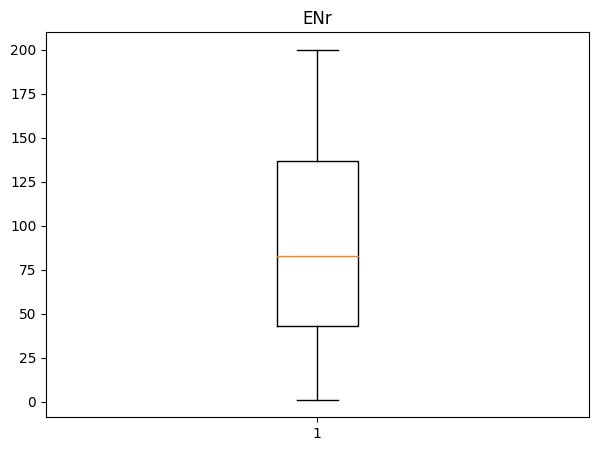

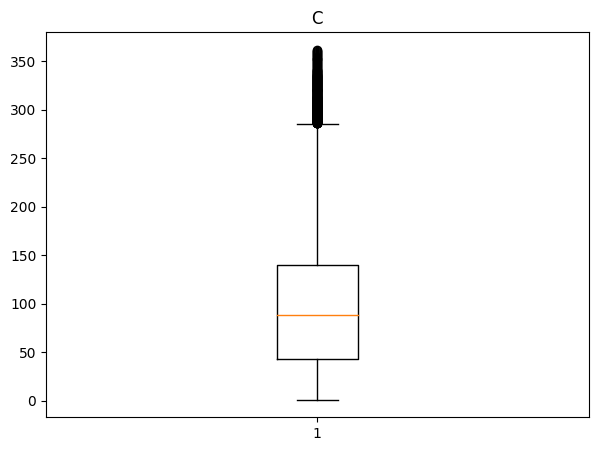

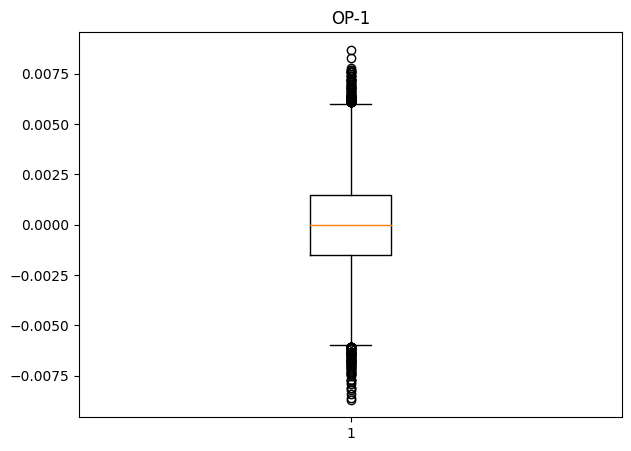

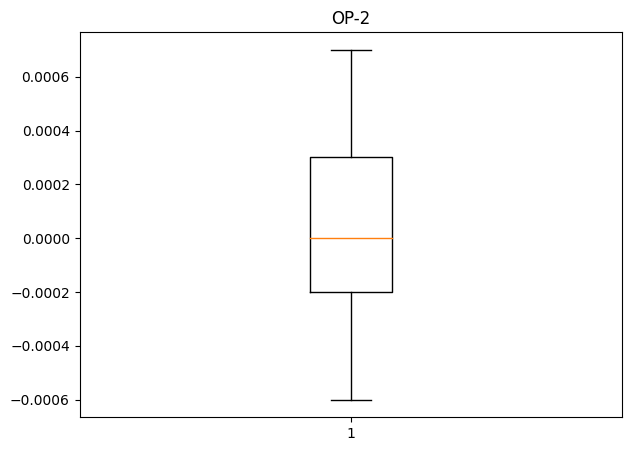

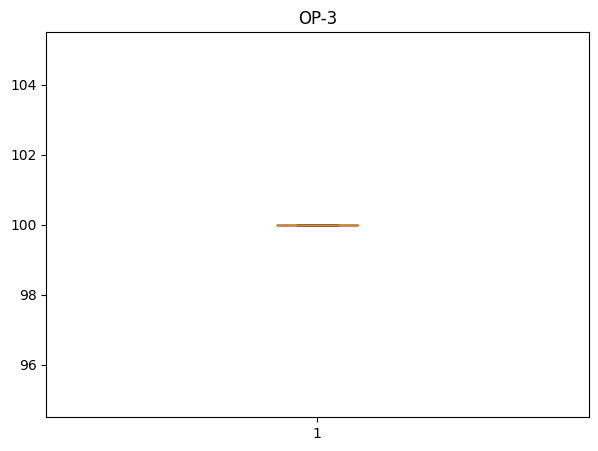

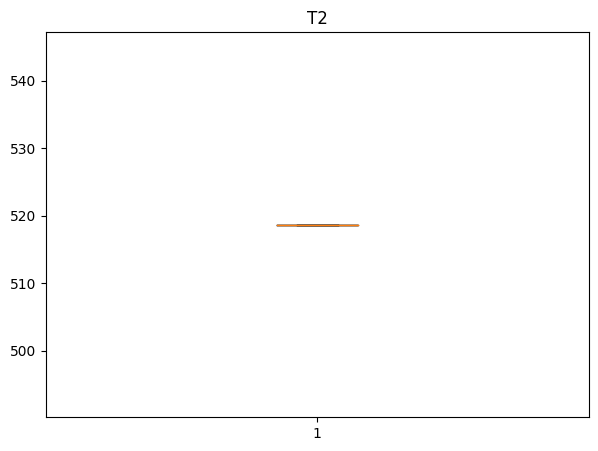

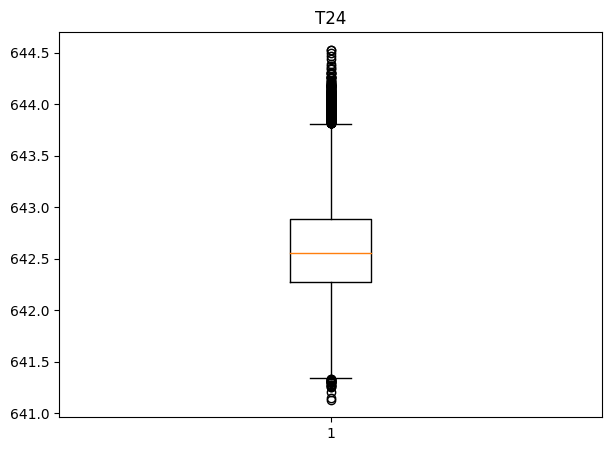

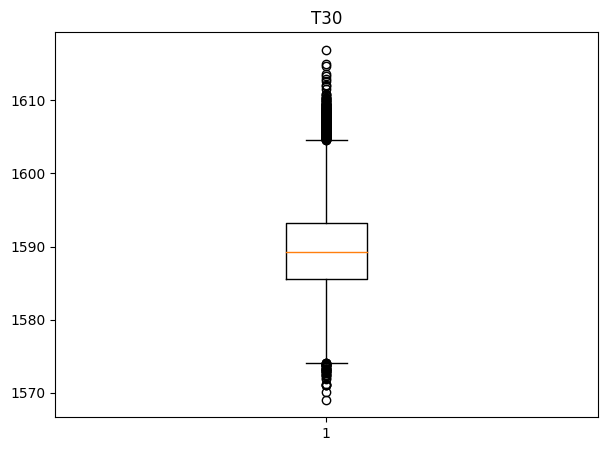

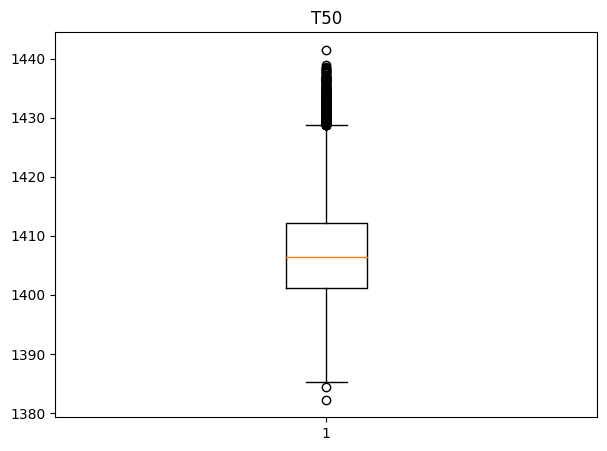

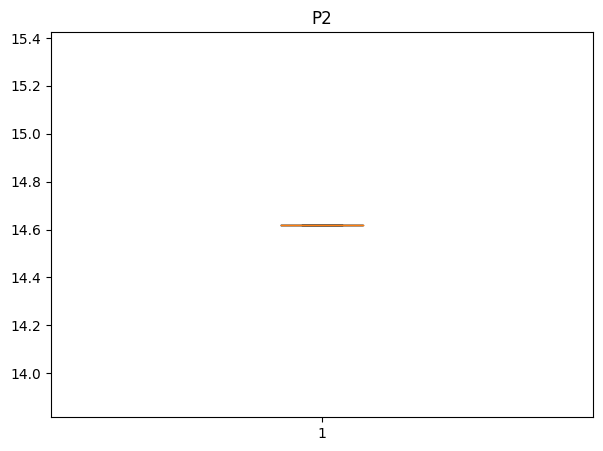

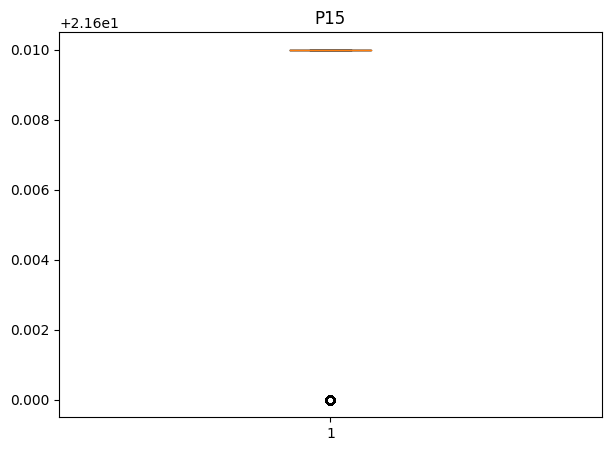

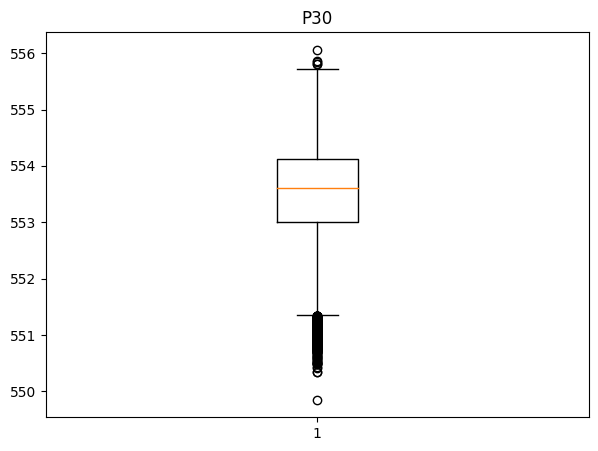

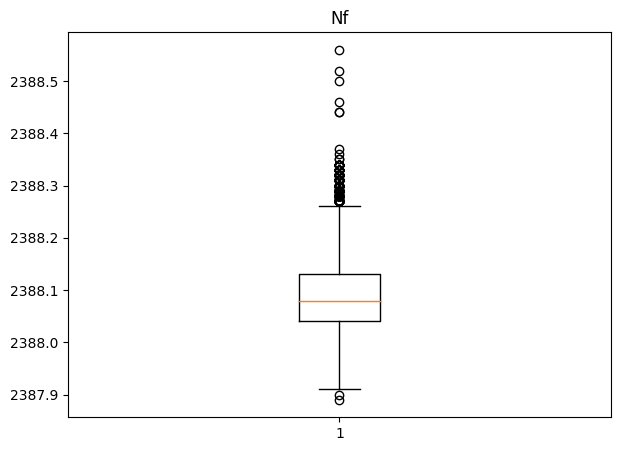

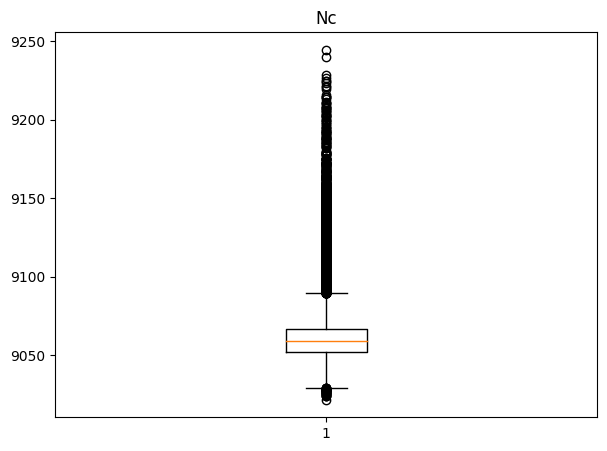

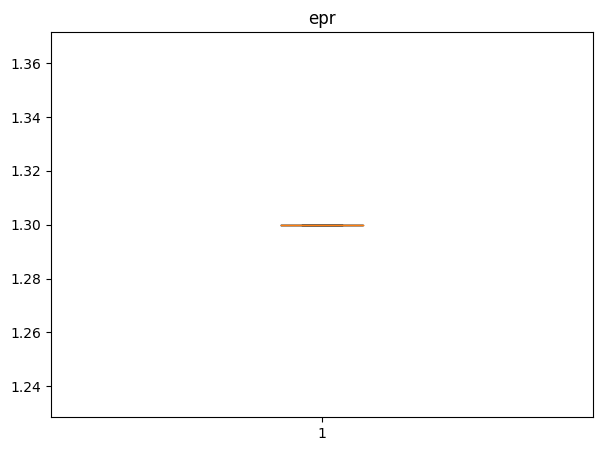

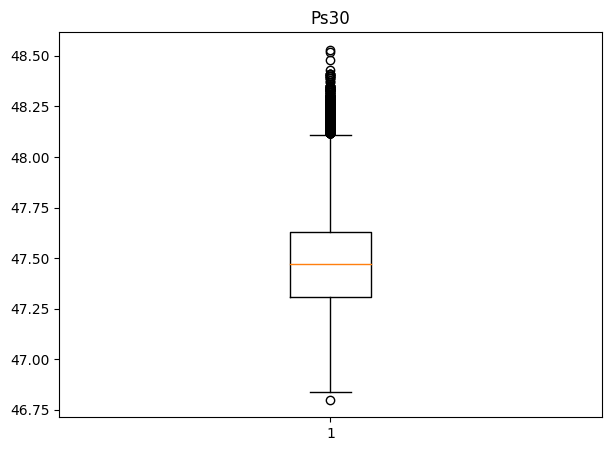

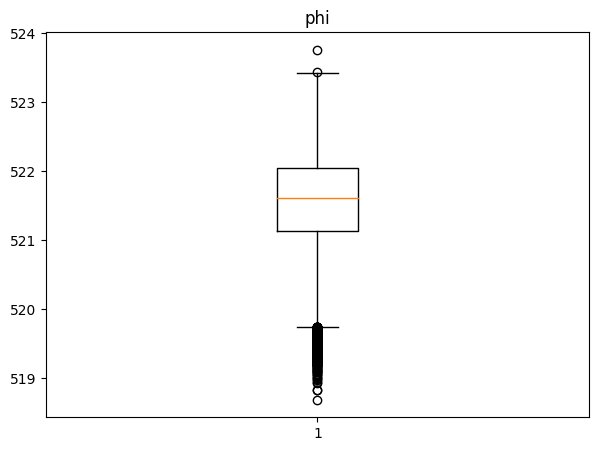

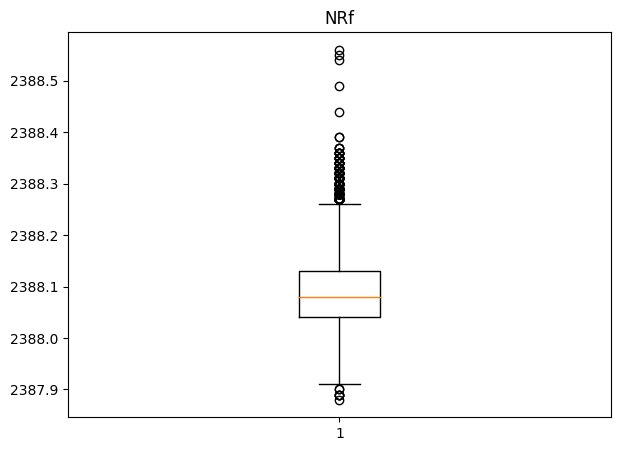

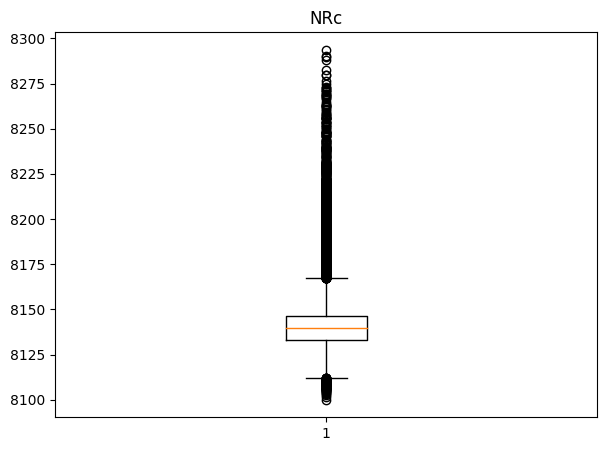

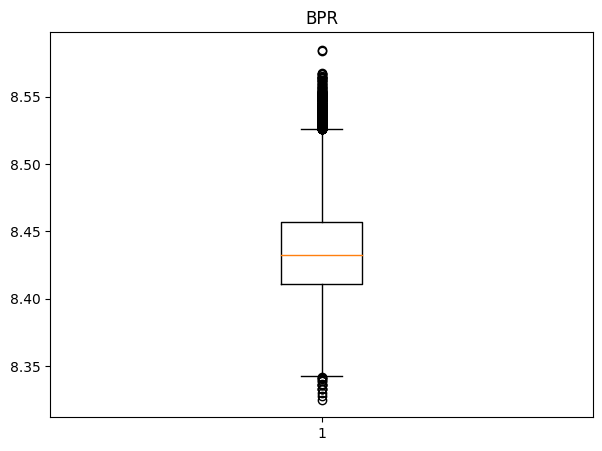

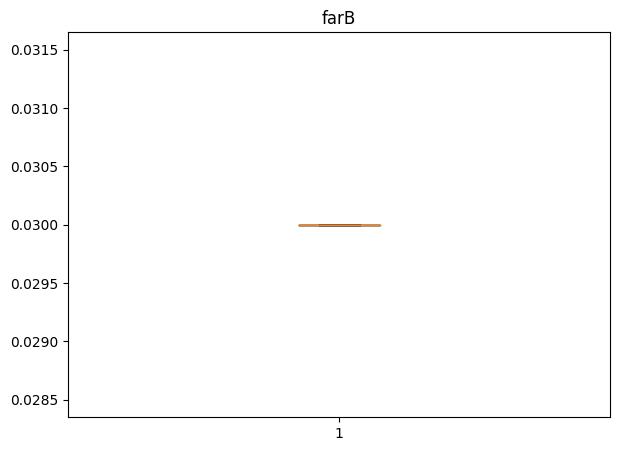

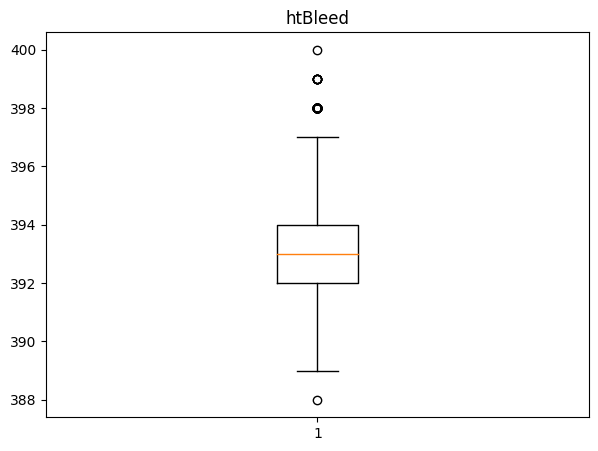

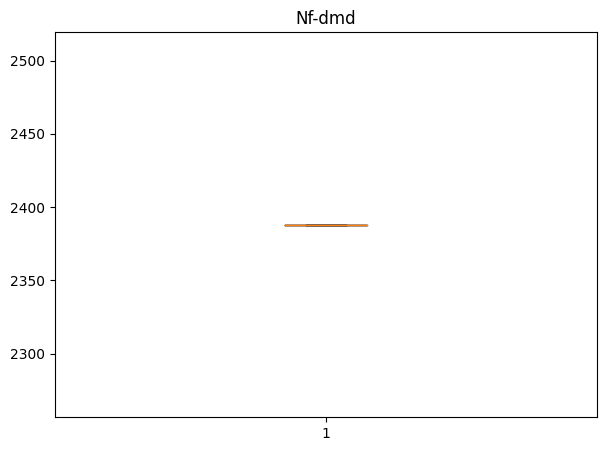

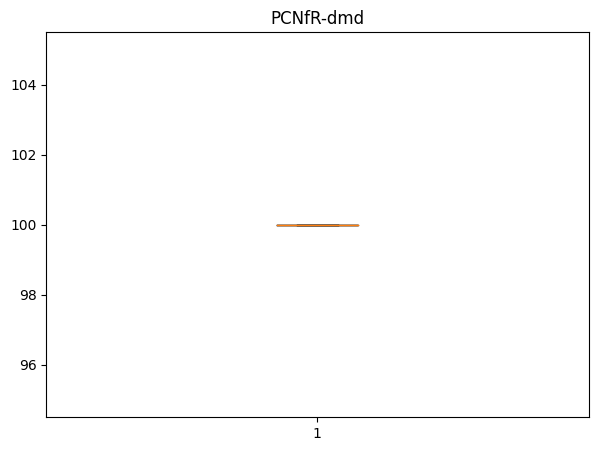

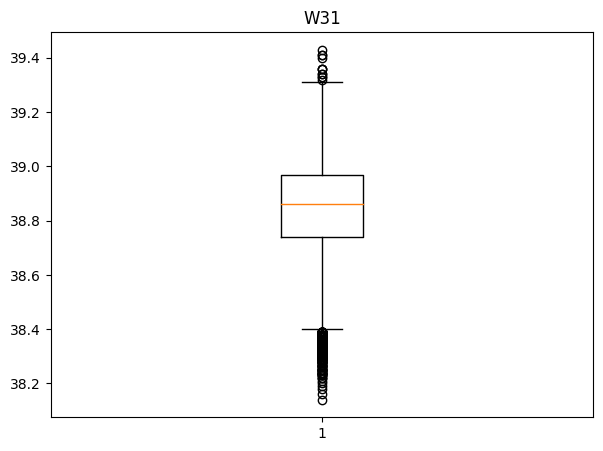

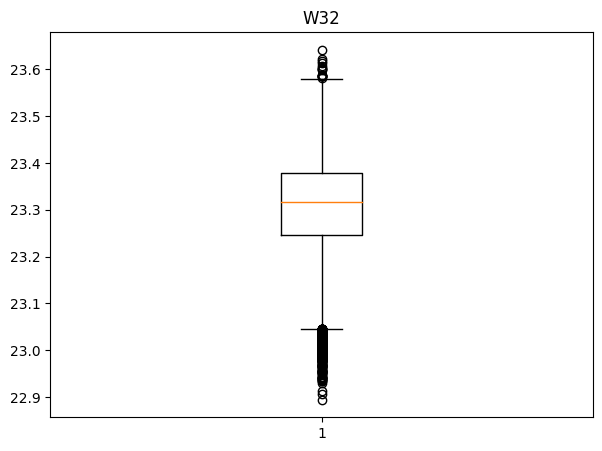

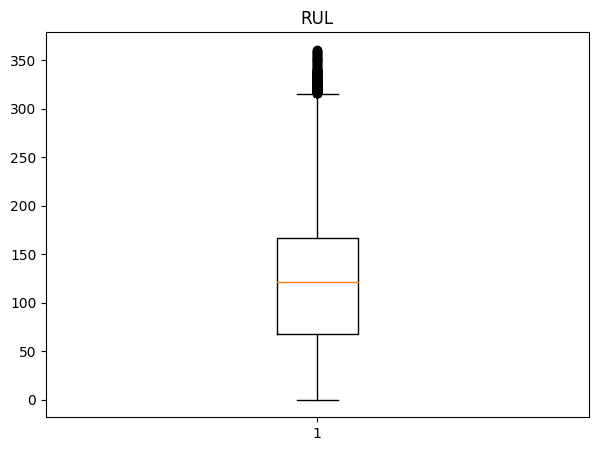

In [140]:
boxplots(turbofan1)

**CONCLUSIONS:**

*   There are no missing or null values, but there are constant values that should be eliminated
*   The subsets have outliers => we will need to filter the data



##Subset Differences

In [141]:
# check if there are notable differences between the testing and training sets (important for training)
def dataset_differences(turbo_train, turbo_test):
  features = turbo_train.iloc[:, :-1]
  target = turbo_train.iloc[:, -1]
  num_features = features.shape[1]

  features_test = turbo_test.iloc[:, :-1]
  target_test = turbo_test.iloc[:, -1]

  fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 6*num_features))

  for i in range(num_features):
      ax = axes[i]
      ax.scatter(features.iloc[:, i], target, color='purple', alpha=0.5, label='Train Set')
      ax.scatter(features_test.iloc[:, i], target_test, color='coral', alpha=0.5, label='Test Set')
      ax.set_xlabel('Feature ' + str(i+1))
      ax.set_ylabel('Target')
      ax.legend()

  plt.tight_layout()
  plt.show()

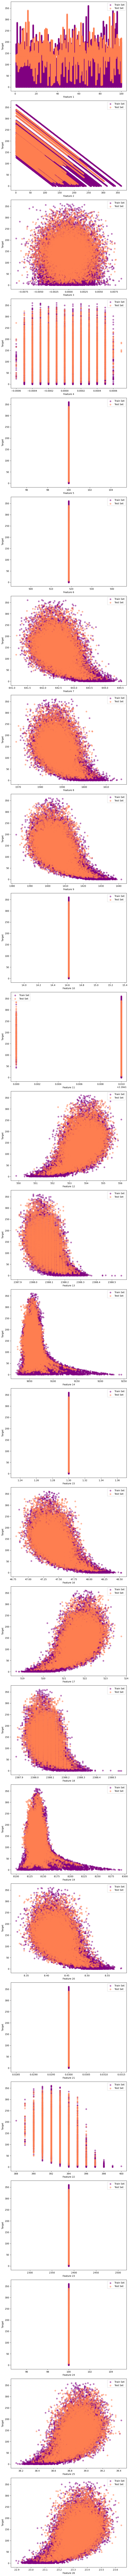

In [142]:
dataset_differences(turbo_train_1, turbo_test_1)

**CONCLUSION**: No significant differences found

##Bivariate - Correlation Analysis

In [143]:
#compute the Pearson Correlation Coefficient (Pearson r) between attribute and RUL
def compute_pearson(turbofan):
  correlation_matrix = turbofan.corr(method='pearson')*100
  target_column = 'RUL'
  correlation = correlation_matrix[target_column]
  return round(correlation, 3)

In [144]:
p1=compute_pearson(turbofan1)
p2=compute_pearson(turbofan2)
p3=compute_pearson(turbofan3)
p4=compute_pearson(turbofan4)

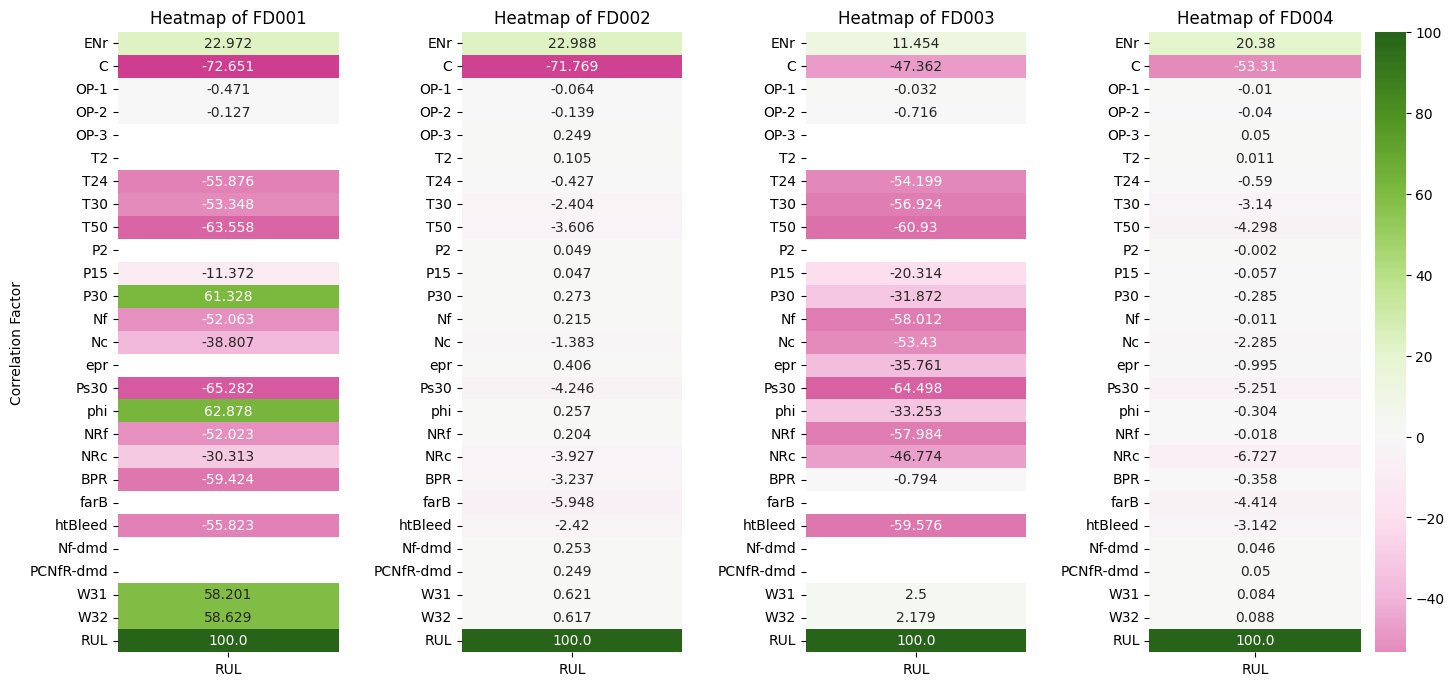

In [145]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})

sns.heatmap(p1.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[0], cbar=False)
axs[0].set_title('Heatmap of FD001')
axs[0].set_ylabel('Correlation Factor')

sns.heatmap(p2.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[1], cbar=False)
axs[1].set_title('Heatmap of FD002')

sns.heatmap(p3.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[2], cbar=False)
axs[2].set_title('Heatmap of FD003')

sns.heatmap(p4.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[3])
axs[3].set_title('Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=2.5)

plt.show()

In [146]:
#plot the complete heatmap for all subsets
def all_correlations(turbofan):
  correlation_matrix = turbofan.corr(method='pearson')
  return round(correlation_matrix, 2)

In [147]:
pear1=all_correlations(turbofan1)
pear2=all_correlations(turbofan2)
pear3=all_correlations(turbofan3)
pear4=all_correlations(turbofan4)

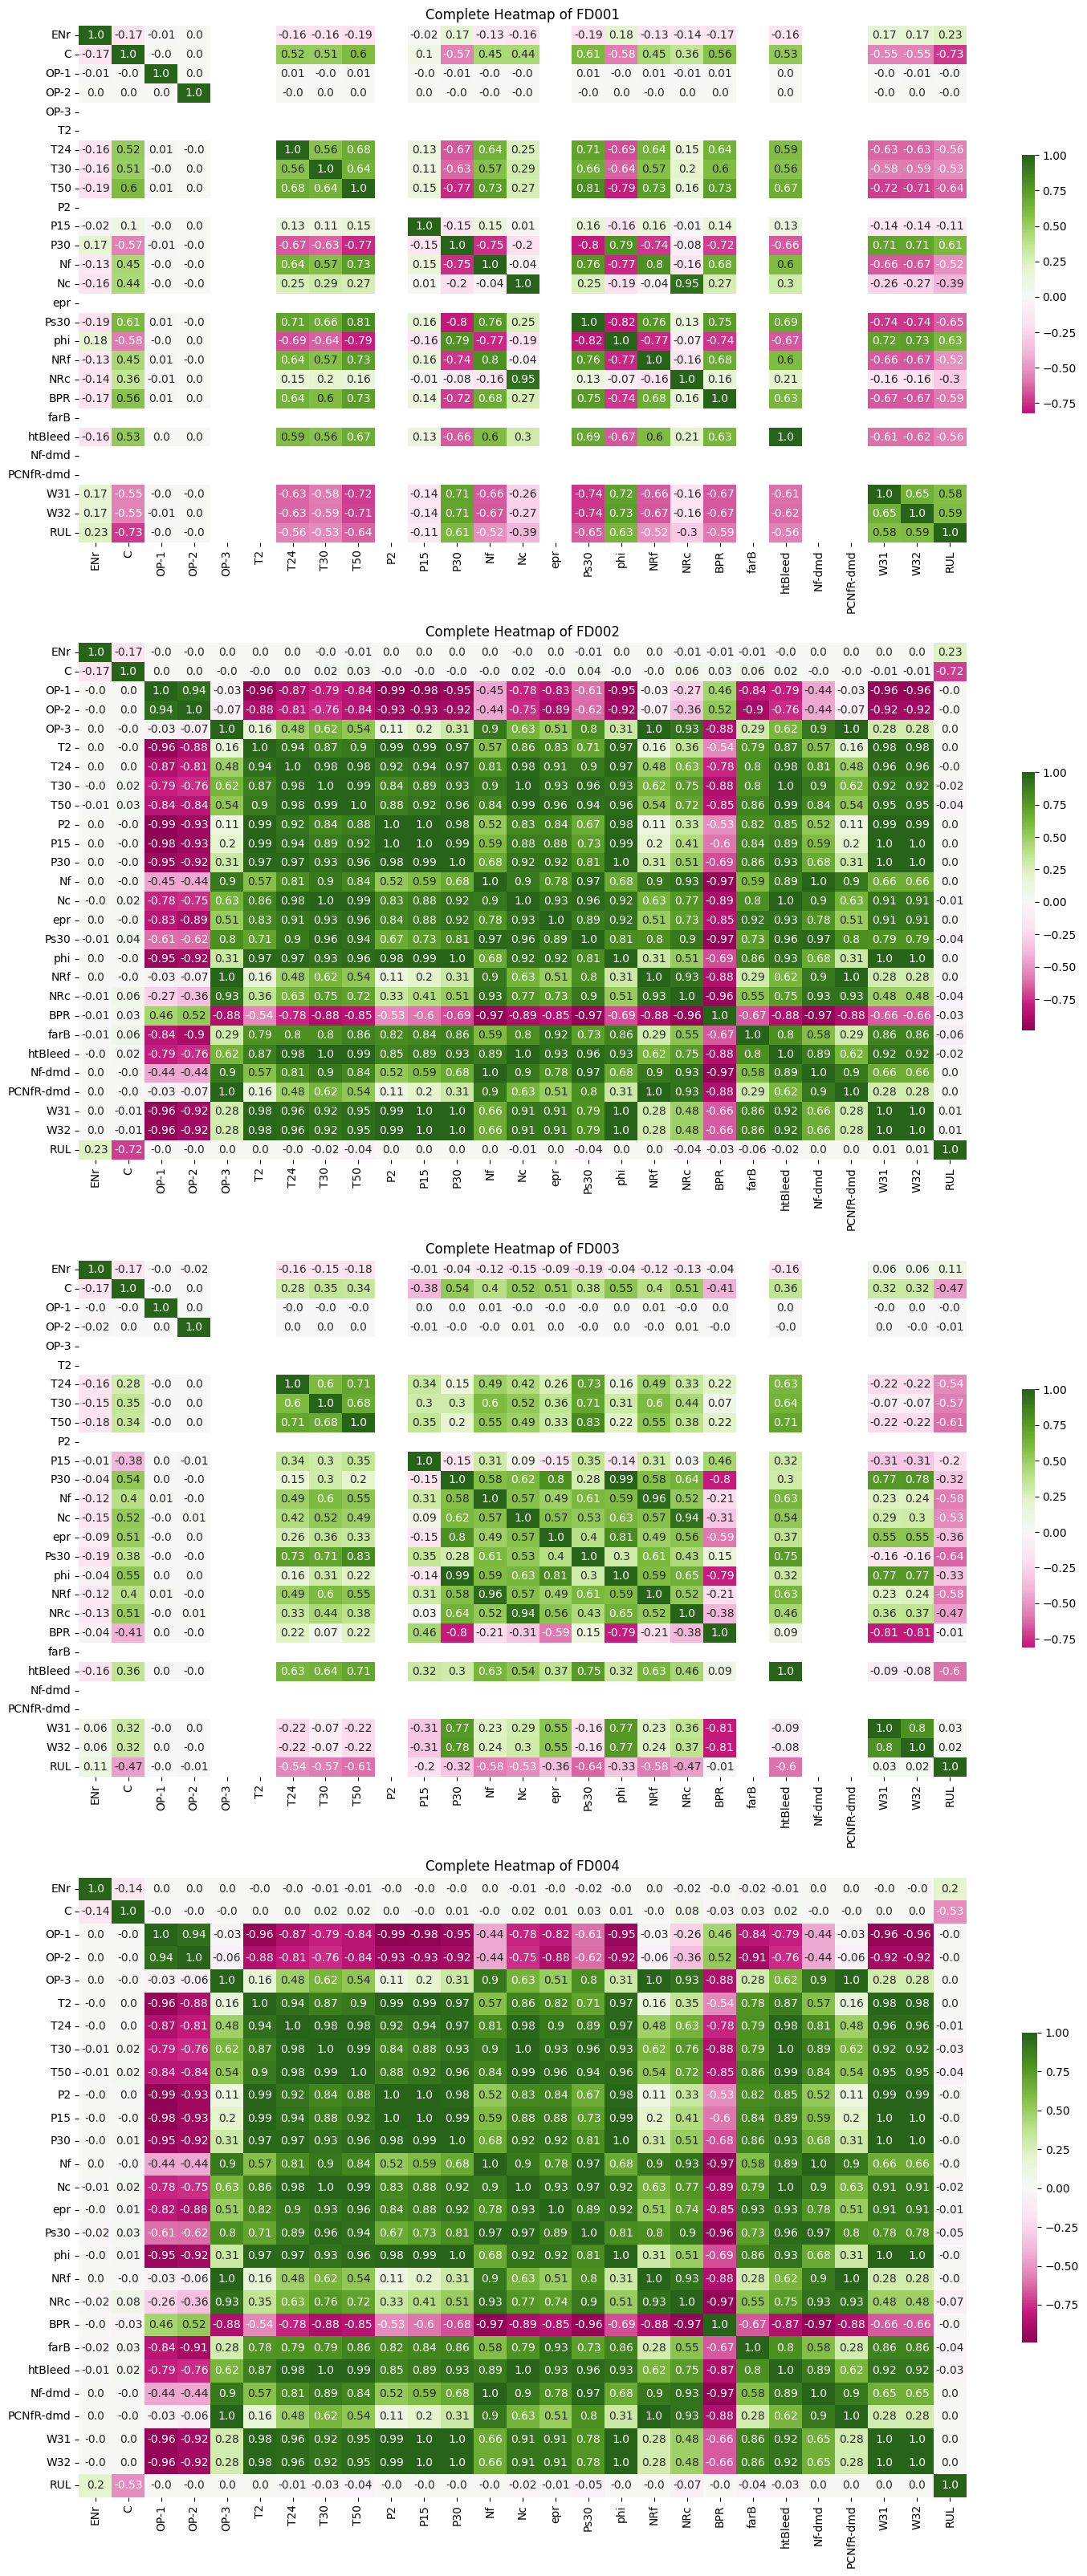

In [148]:
fig, axs = plt.subplots(4, 1, figsize=(15, 35), gridspec_kw={'height_ratios': [1, 1, 1, 1.2]})

sns.heatmap(pear1, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[0], cbar_kws={"shrink": .5})
axs[0].set_title('Complete Heatmap of FD001')

sns.heatmap(pear2, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[1], cbar_kws={"shrink": .5})
axs[1].set_title('Complete Heatmap of FD002')

sns.heatmap(pear3, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[2], cbar_kws={"shrink": .5})
axs[2].set_title('Complete Heatmap of FD003')

sns.heatmap(pear4, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[3], cbar_kws={"shrink": .5})
axs[3].set_title('Complete Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [149]:
# find the sensors with 1.0 (maximum) correlation
sensor_pairs = []
for i, pear in enumerate([pear1, pear2, pear3, pear4], start=1):
    for sensor1, row in pear.iterrows():
        for sensor2, correlation in row.items():
            if correlation == 1 and sensor1 != sensor2:
                sensor_pairs.append((f'FD00{i}_{sensor1}', f'FD00{i}_{sensor2}'))

sensor_pairs_list= pd.DataFrame(sensor_pairs, columns=['Sensor1', 'Sensor2'])

In [150]:
sensor_pairs_list

Sensor1          Sensor2
0   FD002_OP-3        FD002_NRf
1   FD002_OP-3  FD002_PCNfR-dmd
2    FD002_T30         FD002_Nc
3    FD002_T30    FD002_htBleed
4     FD002_P2        FD002_P15
..         ...              ...
59   FD004_W31        FD004_W32
60   FD004_W32        FD004_P15
61   FD004_W32        FD004_P30
62   FD004_W32        FD004_phi
63   FD004_W32        FD004_W31

[64 rows x 2 columns]

In [151]:
# exclusions based on Correlation Analysis
columns_to_drop1 = ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf-dmd', 'PCNfR-dmd']
columns_to_drop3 = ['T2', 'P2', 'epr', 'farB', 'Nf-dmd', 'PCNfR-dmd']

In [152]:
columns_to_drop2=['NRf', 'T30', 'Nc', 'P15', 'P30', 'phi', 'W32', 'Nf']
columns_to_drop4=['NRf', 'T30', 'Nc', 'P2', 'W31', 'P30', 'phi', 'Nf']

In [153]:
turbofan1.drop(columns=columns_to_drop1, inplace=True)
turbofan3.drop(columns=columns_to_drop3, inplace=True)

In [154]:
turbofan2.drop(columns=columns_to_drop2, inplace=True)
turbofan4.drop(columns=columns_to_drop4, inplace=True)

In [155]:
turbofan1

ENr    C    OP-1    OP-2   OP-3     T24      T30      T50     P30  \
0        1    1 -0.0007 -0.0004  100.0  641.82  1589.70  1400.60  554.36   
1        1    2  0.0019 -0.0003  100.0  642.15  1591.82  1403.14  553.75   
2        1    3 -0.0043  0.0003  100.0  642.35  1587.99  1404.20  554.26   
3        1    4  0.0007  0.0000  100.0  642.35  1582.79  1401.87  554.45   
4        1    5 -0.0019 -0.0002  100.0  642.37  1582.85  1406.22  554.00   
...    ...  ...     ...     ...    ...     ...      ...      ...     ...   
33722  200  194  0.0049  0.0000  100.0  643.24  1599.45  1415.79  553.41   
33723  200  195 -0.0011 -0.0001  100.0  643.22  1595.69  1422.05  553.22   
33724  200  196 -0.0006 -0.0003  100.0  643.44  1593.15  1406.82  553.04   
33725  200  197 -0.0038  0.0001  100.0  643.26  1594.99  1419.36  553.37   
33726  200  198  0.0013  0.0003  100.0  642.95  1601.62  1424.99  552.48   

            Nf       Nc   Ps30     phi      NRf      NRc     BPR  htBleed  \
0      2388.06  9046.19  47.47  521.66  2388.02  8138.62  8.4195      392   
1      2388.04  9044.07  47.49  522.28  2388.07  8131.49  8.4318      392   
2      2388.08  9052.94  47.27  522.42  2388.03  8133.23  8.4178      390   
3      2388.11  9049.48  47.13  522.86  2388.08  8133.83  8.3682      392   
4      2388.06  9055.15  47.28  522.19  2388.04  8133.80  8.4294      393   
...        ...      ...    ...     ...      ...      ...     ...      ...   
33722  2388.02  9142.37  47.69  520.69  2388.00  8213.28  8.4715      394   
33723  2388.05  9140.68  47.60  521.05  2388.09  8210.85  8.4512      395   
33724  2388.11  9146.81  47.57  521.18  2388.04  8217.24  8.4569      395   
33725  2388.07  9148.85  47.61  521.33  2388.08  8220.48  8.4711      395   
33726  2388.06  9155.03  47.80  521.07  2388.05  8214.64  8.4903      396   

         W31      W32  RUL  
0      39.06  23.4190  191  
1      39.00  23.4236  190  
2      38.95  23.3442  189  
3      38.88  23.3739  188  
4      38.90  23.4044  187  
...      ...      ...  ...  
33722  38.65  23.1974   24  
33723  38.57  23.2771   23  
33724  38.62  23.2051   22  
33725  38.66  23.2699   21  
33726  38.70  23.1855   20  

[33727 rows x 20 columns]

#Preprocessing

##Filtering

In [156]:
#apply the moving median filtering technique
def moving_median(turbofan, window_size, period):
    columns_to_filter = turbofan.columns.drop(['ENr', 'C', 'RUL', 'OP-1', 'OP-2', 'OP-3'])
    filtered_turbo = turbofan.copy()
    grouped = filtered_turbo.groupby('ENr')[columns_to_filter]
    filtered_turbo[columns_to_filter] = grouped.rolling(window=window_size, min_periods=period, axis=0).median().reset_index(drop=True)

    return filtered_turbo

In [157]:
filtered_turbo1=moving_median(turbofan1, 5, 1)
filtered_turbo2=moving_median(turbofan2, 5, 1)
filtered_turbo3=moving_median(turbofan3, 5, 1)
filtered_turbo4=moving_median(turbofan4, 5, 1)

In [158]:
filtered_turbo1

ENr    C    OP-1    OP-2   OP-3      T24       T30       T50      P30  \
0        1    1 -0.0007 -0.0004  100.0  641.820  1589.700  1400.600  554.360   
1        1    2  0.0019 -0.0003  100.0  641.985  1590.760  1401.870  554.055   
2        1    3 -0.0043  0.0003  100.0  642.150  1589.700  1403.140  554.260   
3        1    4  0.0007  0.0000  100.0  642.250  1588.845  1402.505  554.310   
4        1    5 -0.0019 -0.0002  100.0  642.350  1587.990  1403.140  554.260   
...    ...  ...     ...     ...    ...      ...       ...       ...      ...   
33722  200  194  0.0049  0.0000  100.0  643.050  1598.180  1415.790  553.240   
33723  200  195 -0.0011 -0.0001  100.0  643.100  1595.690  1415.790  553.220   
33724  200  196 -0.0006 -0.0003  100.0  643.220  1595.690  1415.790  553.180   
33725  200  197 -0.0038  0.0001  100.0  643.240  1595.600  1415.790  553.220   
33726  200  198  0.0013  0.0003  100.0  643.240  1595.690  1419.360  553.220   

            Nf        Nc   Ps30     phi       NRf       NRc      BPR  htBleed  \
0      2388.06  9046.190  47.47  521.66  2388.020  8138.620  8.41950    392.0   
1      2388.05  9045.130  47.48  521.97  2388.045  8135.055  8.42565    392.0   
2      2388.06  9046.190  47.47  522.28  2388.030  8133.230  8.41950    392.0   
3      2388.07  9047.835  47.37  522.35  2388.050  8133.530  8.41865    392.0   
4      2388.06  9049.480  47.28  522.28  2388.040  8133.800  8.41950    392.0   
...        ...       ...    ...     ...       ...       ...      ...      ...   
33722  2388.05  9139.880  47.58  521.23  2388.070  8210.240  8.47150    395.0   
33723  2388.05  9140.680  47.60  521.05  2388.070  8210.850  8.45120    395.0   
33724  2388.05  9141.920  47.58  521.05  2388.050  8213.280  8.45120    395.0   
33725  2388.07  9142.370  47.60  521.18  2388.050  8213.570  8.45690    395.0   
33726  2388.06  9146.810  47.61  521.07  2388.050  8214.640  8.47110    395.0   

          W31       W32  RUL  
0      39.060  23.41900  191  
1      39.030  23.42130  190  
2      39.000  23.41900  189  
3      38.975  23.39645  188  
4      38.950  23.40440  187  
...       ...       ...  ...  
33722  38.740  23.22790   24  
33723  38.650  23.22790   23  
33724  38.630  23.21480   22  
33725  38.630  23.26990   21  
33726  38.650  23.20510   20  

[33727 rows x 20 columns]

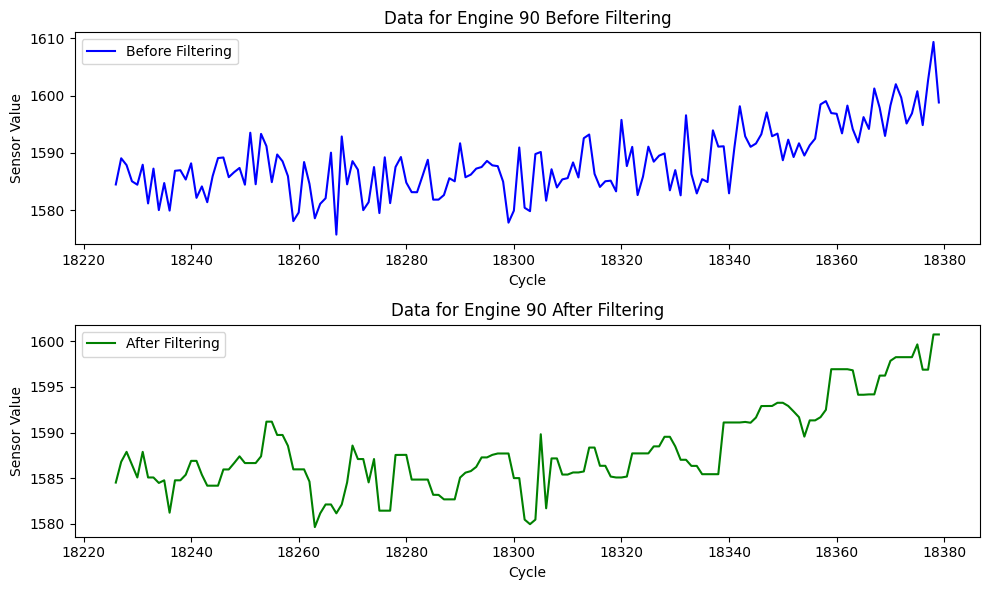

In [159]:
#comparison of sensor T30 for engine 90 before and after filtering
def before_and_after(turbofan, filtered_turbo, engine_number):
    engine_data_before = turbofan[turbofan['ENr'] == engine_number]
    engine_data_after = filtered_turbo[filtered_turbo['ENr'] == engine_number]

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(engine_data_before['T30'], label='Before Filtering', color='blue')
    plt.title(f'Data for Engine {engine_number} Before Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(engine_data_after['T30'], label='After Filtering', color='green')
    plt.title(f'Data for Engine {engine_number} After Filtering')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

engine_number = 90
before_and_after(turbofan1, filtered_turbo1, engine_number)

##Normalization

In [160]:
# perform z-score normalization (standardization)
def z_score(turbofan):
  scaler = StandardScaler()
  normalized_turbo = turbofan.copy()
  columns_to_normalize = turbofan.columns.drop(['ENr', 'C', 'RUL'])
  normalized_turbo[columns_to_normalize] = scaler.fit_transform(turbofan[columns_to_normalize])
  return normalized_turbo

In [161]:
normalized_turbo1=z_score(filtered_turbo1)
normalized_turbo2=z_score(filtered_turbo2)
normalized_turbo3=z_score(filtered_turbo3)
normalized_turbo4=z_score(filtered_turbo4)

In [162]:
normalized_turbo1

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
0        1    1 -0.314711 -1.373690   0.0 -1.960981  0.051092 -0.860848   
1        1    2  0.870755 -1.032895   0.0 -1.539943  0.278279 -0.692696   
2        1    3 -1.956125  1.011877   0.0 -1.118905  0.051092 -0.524544   
3        1    4  0.323617 -0.010509   0.0 -0.863730 -0.132158 -0.608620   
4        1    5 -0.861849 -0.692099   0.0 -0.608555 -0.315408 -0.524544   
...    ...  ...       ...       ...   ...       ...       ...       ...   
33722  200  194  2.238601 -0.010509   0.0  1.177669  1.868590  1.150357   
33723  200  195 -0.497090 -0.351304   0.0  1.305256  1.334915  1.150357   
33724  200  196 -0.269116 -1.032895   0.0  1.611466  1.334915  1.150357   
33725  200  197 -1.728151  0.330287   0.0  1.662501  1.315625  1.150357   
33726  200  198  0.597186  1.011877   0.0  1.662501  1.334915  1.623037   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
0      1.104758 -0.413888 -0.902209 -0.072214  0.157062 -1.062438 -0.196619   
1      0.695026 -0.578089 -0.961536 -0.028486  0.650019 -0.653695 -0.426444   
2      0.970419 -0.413888 -0.902209 -0.072214  1.142976 -0.898941 -0.544096   
3      1.037588 -0.249687 -0.810141 -0.509501  1.254289 -0.571947 -0.524756   
4      0.970419 -0.413888 -0.718073 -0.903059  1.142976 -0.735444 -0.507350   
...         ...       ...       ...       ...       ...       ...       ...   
33722 -0.399832 -0.578089  4.341474  0.408801 -0.526717 -0.244952  4.420501   
33723 -0.426700 -0.578089  4.386248  0.496258 -0.812950 -0.244952  4.459826   
33724 -0.480435 -0.578089  4.455649  0.408801 -0.812950 -0.571947  4.616481   
33725 -0.426700 -0.249687  4.480835  0.496258 -0.606226 -0.571947  4.635176   
33726 -0.426700 -0.413888  4.729335  0.539987 -0.781146 -0.571947  4.704156   

            BPR   htBleed       W31       W32  RUL  
0     -0.509848 -0.755387  1.452095  1.253265  191  
1     -0.307572 -0.755387  1.244488  1.279766  190  
2     -0.509848 -0.755387  1.036882  1.253265  189  
3     -0.537805 -0.755387  0.863876  0.993444  188  
4     -0.509848 -0.755387  0.690871  1.085044  187  
...         ...       ...       ...       ...  ...  
33722  1.200454  1.689970 -0.762375 -0.948586   24  
33723  0.532779  1.689970 -1.385195 -0.948586   23  
33724  0.532779  1.689970 -1.523599 -1.099524   22  
33725  0.720254  1.689970 -1.523599 -0.464663   21  
33726  1.187298  1.689970 -1.385195 -1.211287   20  

[33727 rows x 20 columns]

##Damage Modeling

In [163]:
#split dataframe into train and test (only train is needed for damage modeling)
def split_dataframe(normalized_turbofan, nr_train):
  turbo_RUL_train = normalized_turbofan[(normalized_turbofan['ENr'] <= nr_train)]
  turbo_RUL_test = normalized_turbofan[(normalized_turbofan['ENr'] > nr_train)]
  return turbo_RUL_train, turbo_RUL_test

In [164]:
turbo1_train, turbo1_test=split_dataframe(normalized_turbo1, nr_train_1)
turbo2_train, turbo2_test=split_dataframe(normalized_turbo2, nr_train_2)
turbo3_train, turbo3_test=split_dataframe(normalized_turbo3, nr_train_3)
turbo4_train, turbo4_test=split_dataframe(normalized_turbo4, nr_train_4)

In [165]:
turbo1_train

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
0        1    1 -0.314711 -1.373690   0.0 -1.960981  0.051092 -0.860848   
1        1    2  0.870755 -1.032895   0.0 -1.539943  0.278279 -0.692696   
2        1    3 -1.956125  1.011877   0.0 -1.118905  0.051092 -0.524544   
3        1    4  0.323617 -0.010509   0.0 -0.863730 -0.132158 -0.608620   
4        1    5 -0.861849 -0.692099   0.0 -0.608555 -0.315408 -0.524544   
...    ...  ...       ...       ...   ...       ...       ...       ...   
20626  100  196 -0.177926 -1.032895   0.0  2.300438  2.217944  2.850416   
20627  100  197 -0.725065 -1.714485   0.0  2.300438  2.217944  2.890137   
20628  100  198  0.186832 -0.010509   0.0  2.300438  2.267240  2.850416   
20629  100  199 -0.497090  1.011877   0.0  2.121816  2.785913  2.850416   
20630  100  200 -1.454582 -1.714485   0.0  2.300438  2.785913  2.850416   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
0      1.104758 -0.413888 -0.902209 -0.072214  0.157062 -1.062438 -0.196619   
1      0.695026 -0.578089 -0.961536 -0.028486  0.650019 -0.653695 -0.426444   
2      0.970419 -0.413888 -0.902209 -0.072214  1.142976 -0.898941 -0.544096   
3      1.037588 -0.249687 -0.810141 -0.509501  1.254289 -0.571947 -0.524756   
4      0.970419 -0.413888 -0.718073 -0.903059  1.142976 -0.735444 -0.507350   
...         ...       ...       ...       ...       ...       ...       ...   
20626 -2.831357  2.377524  0.294396  3.032522 -2.943797  2.207505  0.022568   
20627 -2.831357  2.377524  0.294396  2.770150 -2.991502  2.207505 -0.128929   
20628 -2.844791  2.377524  0.200929  2.638964 -2.991502  2.534499 -0.128929   
20629 -3.489615  2.377524  0.200929  2.638964 -2.991502  2.534499 -0.153427   
20630 -3.597086  2.541725  0.179661  2.638964 -3.007404  2.534499 -0.262376   

            BPR   htBleed       W31       W32  RUL  
0     -0.509848 -0.755387  1.452095  1.253265  191  
1     -0.307572 -0.755387  1.244488  1.279766  190  
2     -0.509848 -0.755387  1.036882  1.253265  189  
3     -0.537805 -0.755387  0.863876  0.993444  188  
4     -0.509848 -0.755387  0.690871  1.085044  187  
...         ...       ...       ...       ...  ...  
20626  2.844975  3.320208 -2.630834 -2.687253    4  
20627  2.844975  1.689970 -3.253654 -2.048935    3  
20628  2.844975  1.689970 -3.253654 -2.048935    2  
20629  3.417268  1.689970 -3.807271 -2.837039    1  
20630  2.595008  2.505089 -3.322856 -2.972998    0  

[20631 rows x 20 columns]

173


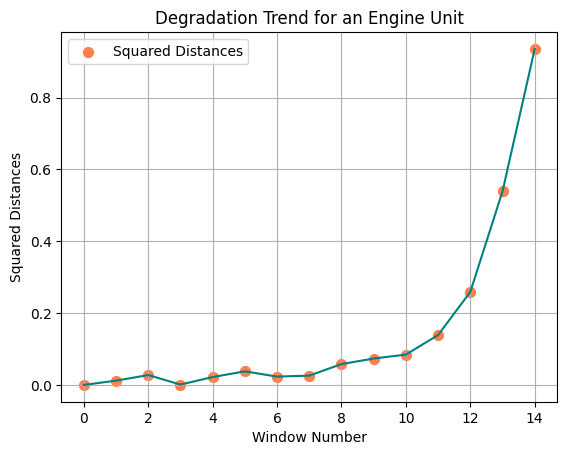

In [166]:
#test the damage modeling algorithm
engine_sensors = normalized_turbo1[normalized_turbo1['ENr'] == 80]
eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
engine_values=eng_sens.values

N = len(engine_sensors)
window_length = 12
Th=0.01
g=N/window_length
centroids=[]
mean_centroids=[]
sq=[]
iruls=[]


windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

for window in windows:
  centroid=window.mean()
  centroids.append(centroid)
  mean_centroid=centroid.mean()
  mean_centroids.append(mean_centroid)

for i in range(len(windows)-1):
  s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
  squared= s**2
  sq.append(squared)
  if squared>=Th:
    irul=N-window_length*i
    iruls.append(irul)
  else:
    i=i+1

print(max(iruls))


plt.scatter(range(len(sq)), sq, color='coral', label='Squared Distances', s=50)
plt.xlabel('Window Number')
plt.ylabel('Squared Distances')
plt.title('Degradation Trend for an Engine Unit')
plt.legend()
plt.grid(True)


plt.plot(range(len(sq)), sq, color='teal', linestyle='-')

In [167]:
#apply the degradation model to all subsets
def degradation_model(normalized_turbo, nr_eng, window_length, Th):
  RULs=[]
  RUL=0
  for i in range (1, nr_eng):
    engine_sensors = normalized_turbo[normalized_turbo['ENr'] == i]
    eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
    engine_values=eng_sens.values

    N = len(engine_sensors)
    g=N/window_length
    centroids=[]
    mean_centroids=[]
    sq=[]
    iruls=[]


    windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

    for window in windows:
      centroid=window.mean()
      centroids.append(centroid)
      mean_centroid=centroid.mean()
      mean_centroids.append(mean_centroid)

    for i in range(len(windows)-1):
      s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
      squared= s**2
      sq.append(squared)
      if squared>=Th:
        irul=N-window_length*i
        iruls.append(irul)
      else:
        i=i+1

    RUL=max(iruls)
    RULs.append(RUL)
  final_RUL=min(RULs)
  return final_RUL


In [168]:
initial_RUL1=degradation_model(normalized_turbo1, nr_train_1, 12, 0.0049)
initial_RUL2=degradation_model(normalized_turbo2, nr_train_2, 12, 0.01)
initial_RUL3=degradation_model(normalized_turbo3, nr_train_3, 12, 0.0016)
initial_RUL4=degradation_model(normalized_turbo4, nr_train_4, 12, 0.04)

In [169]:
print("Minimum initial (w=12, th=0.0049) RUL for FD001:", initial_RUL1)
print("Minimum initial (w=12, th=0.01) RUL for FD002:", initial_RUL2)
print("Minimum initial (w=12, th=0.0016) RUL for FD003:", initial_RUL3)
print("Minimum initial (w=12, th=0.04) RUL for FD001:", initial_RUL4)

Minimum initial (w=12, th=0.0049) RUL for FD001: 63
Minimum initial (w=12, th=0.01) RUL for FD002: 105
Minimum initial (w=12, th=0.0016) RUL for FD003: 68
Minimum initial (w=12, th=0.04) RUL for FD001: 103


##RUL Assignation

In [170]:
#assign the initial RUL for the training set
def RUL_train(turbo_RUL_train, initial_RUL):
  turbo_RUL_train = turbo_RUL_train.copy()
  max_cycle = turbo_RUL_train.groupby('ENr')['C'].transform('max')
  turbo_RUL_train['RUL'] = initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_train['C'] - (max_cycle - initial_RUL)
  turbo_RUL_train.loc[turbo_RUL_train['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_train

In [171]:
turbo1_train=RUL_train(turbo1_train, initial_RUL1)

In [172]:
turbo1_train

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
0        1    1 -0.314711 -1.373690   0.0 -1.960981  0.051092 -0.860848   
1        1    2  0.870755 -1.032895   0.0 -1.539943  0.278279 -0.692696   
2        1    3 -1.956125  1.011877   0.0 -1.118905  0.051092 -0.524544   
3        1    4  0.323617 -0.010509   0.0 -0.863730 -0.132158 -0.608620   
4        1    5 -0.861849 -0.692099   0.0 -0.608555 -0.315408 -0.524544   
...    ...  ...       ...       ...   ...       ...       ...       ...   
20626  100  196 -0.177926 -1.032895   0.0  2.300438  2.217944  2.850416   
20627  100  197 -0.725065 -1.714485   0.0  2.300438  2.217944  2.890137   
20628  100  198  0.186832 -0.010509   0.0  2.300438  2.267240  2.850416   
20629  100  199 -0.497090  1.011877   0.0  2.121816  2.785913  2.850416   
20630  100  200 -1.454582 -1.714485   0.0  2.300438  2.785913  2.850416   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
0      1.104758 -0.413888 -0.902209 -0.072214  0.157062 -1.062438 -0.196619   
1      0.695026 -0.578089 -0.961536 -0.028486  0.650019 -0.653695 -0.426444   
2      0.970419 -0.413888 -0.902209 -0.072214  1.142976 -0.898941 -0.544096   
3      1.037588 -0.249687 -0.810141 -0.509501  1.254289 -0.571947 -0.524756   
4      0.970419 -0.413888 -0.718073 -0.903059  1.142976 -0.735444 -0.507350   
...         ...       ...       ...       ...       ...       ...       ...   
20626 -2.831357  2.377524  0.294396  3.032522 -2.943797  2.207505  0.022568   
20627 -2.831357  2.377524  0.294396  2.770150 -2.991502  2.207505 -0.128929   
20628 -2.844791  2.377524  0.200929  2.638964 -2.991502  2.534499 -0.128929   
20629 -3.489615  2.377524  0.200929  2.638964 -2.991502  2.534499 -0.153427   
20630 -3.597086  2.541725  0.179661  2.638964 -3.007404  2.534499 -0.262376   

            BPR   htBleed       W31       W32  RUL  
0     -0.509848 -0.755387  1.452095  1.253265   63  
1     -0.307572 -0.755387  1.244488  1.279766   63  
2     -0.509848 -0.755387  1.036882  1.253265   63  
3     -0.537805 -0.755387  0.863876  0.993444   63  
4     -0.509848 -0.755387  0.690871  1.085044   63  
...         ...       ...       ...       ...  ...  
20626  2.844975  3.320208 -2.630834 -2.687253    4  
20627  2.844975  1.689970 -3.253654 -2.048935    3  
20628  2.844975  1.689970 -3.253654 -2.048935    2  
20629  3.417268  1.689970 -3.807271 -2.837039    1  
20630  2.595008  2.505089 -3.322856 -2.972998    0  

[20631 rows x 20 columns]

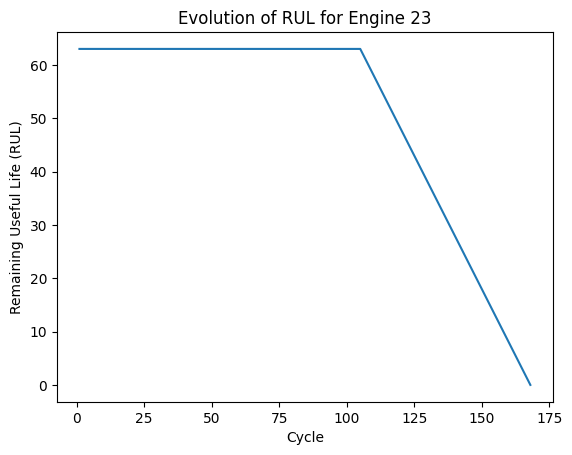

In [173]:
#realsitic RUL trajectory
engine_number = 23
engine_df = turbo1_train[turbo1_train['ENr'] == engine_number]

plt.plot(engine_df['C'], engine_df['RUL'])
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title(f'Evolution of RUL for Engine {engine_number}')
plt.show()

In [174]:
turbo2_train=RUL_train(turbo2_train, initial_RUL2)
turbo3_train=RUL_train(turbo3_train, initial_RUL3)
turbo4_train=RUL_train(turbo4_train, initial_RUL4)

In [175]:
#assign RUL for the testing set
def RUL_test(turbo_RUL_test, initial_RUL, nr_train, y_RUL):
    turbo_RUL_test = turbo_RUL_test.copy()
    y_RUL_series = y_RUL[0]
    adjusted_engine_numbers = turbo_RUL_test['ENr'].values - nr_train-1
    max_cycle = turbo_RUL_test.groupby('ENr')['C'].transform('max')+ y_RUL_series.iloc[adjusted_engine_numbers].values
    turbo_RUL_test['RUL'] = initial_RUL
    turbo_RUL_test.loc[turbo_RUL_test['C'] > max_cycle - initial_RUL, 'RUL'] -= turbo_RUL_test['C'] - (max_cycle - initial_RUL)
    turbo_RUL_test.loc[turbo_RUL_test['RUL'] < 0, 'RUL'] = 0
    return turbo_RUL_test

In [176]:
turbo1_test=RUL_test(turbo1_test, initial_RUL1, nr_train_1, y_RUL_1)

In [177]:
turbo1_test

ENr    C      OP-1      OP-2  OP-3       T24       T30       T50  \
20631  101    1  1.053135  1.011877   0.0  1.101116 -0.894093 -1.177292   
20632  101    2 -1.226608 -1.032895   0.0 -0.570279 -0.555455 -1.361995   
20633  101    3  0.141238  0.330287   0.0 -0.327863 -0.540452 -1.177292   
20634  101    4  1.919437 -0.010509   0.0 -0.353380 -0.717272 -0.970081   
20635  101    5  0.642781 -0.010509   0.0 -0.327863 -0.540452 -0.762870   
...    ...  ...       ...       ...   ...       ...       ...       ...   
33722  200  194  2.238601 -0.010509   0.0  1.177669  1.868590  1.150357   
33723  200  195 -0.497090 -0.351304   0.0  1.305256  1.334915  1.150357   
33724  200  196 -0.269116 -1.032895   0.0  1.611466  1.334915  1.150357   
33725  200  197 -1.728151  0.330287   0.0  1.662501  1.315625  1.150357   
33726  200  198  0.597186  1.011877   0.0  1.662501  1.334915  1.623037   

            P30        Nf        Nc      Ps30       phi       NRf       NRc  \
20631  0.486801 -0.742289 -0.679455 -1.252889  0.252473 -0.898941 -1.039202   
20632  1.124908 -0.988590 -0.560522 -0.596959  0.602314 -0.653695 -0.585677   
20633  0.768912 -0.742289 -0.441589  0.058972  0.650019 -0.898941 -0.745878   
20634  0.742044 -0.824390 -0.560522 -0.422044  0.451246 -0.735444 -0.655624   
20635  0.768912 -0.906490 -0.679455 -0.771873  0.650019 -0.898941 -0.745878   
...         ...       ...       ...       ...       ...       ...       ...   
33722 -0.399832 -0.578089  4.341474  0.408801 -0.526717 -0.244952  4.420501   
33723 -0.426700 -0.578089  4.386248  0.496258 -0.812950 -0.244952  4.459826   
33724 -0.480435 -0.578089  4.455649  0.408801 -0.812950 -0.571947  4.616481   
33725 -0.426700 -0.249687  4.480835  0.496258 -0.606226 -0.571947  4.635176   
33726 -0.426700 -0.413888  4.729335  0.539987 -0.781146 -0.571947  4.704156   

            BPR   htBleed       W31       W32  RUL  
20631 -0.980181 -0.755387  0.068051  0.729015   63  
20632 -1.389666 -0.347828  0.621669  0.833289   63  
20633 -0.980181  0.059732  1.175286  0.937563   63  
20634 -1.202191 -0.347828  1.106084  0.834441   63  
20635 -1.049251 -0.755387  1.036882  0.937563   63  
...         ...       ...       ...       ...  ...  
33722  1.200454  1.689970 -0.762375 -0.948586   24  
33723  0.532779  1.689970 -1.385195 -0.948586   23  
33724  0.532779  1.689970 -1.523599 -1.099524   22  
33725  0.720254  1.689970 -1.523599 -0.464663   21  
33726  1.187298  1.689970 -1.385195 -1.211287   20  

[13096 rows x 20 columns]

In [178]:
turbo2_test=RUL_test(turbo2_test, initial_RUL2, nr_train_2, y_RUL_2)
turbo3_test=RUL_test(turbo3_test, initial_RUL3, nr_train_3, y_RUL_3)
turbo4_test=RUL_test(turbo4_test, initial_RUL4, nr_train_4, y_RUL_4)

##Prepare for Training

In [179]:
#split data into arrays
def train_split(turbo_train, turbo_test):
  X_train=turbo_train.iloc[:, :-1]
  y_train=turbo_train.iloc[:, -1]

  X_test=turbo_test.iloc[:, :-1]
  y_test=turbo_test.iloc[:, -1]
  return X_train, y_train, X_test, y_test

In [180]:
X_train, y_train, X_test, y_test=train_split(turbo1_train, turbo1_test)
y_test

20631    63
20632    63
20633    63
20634    63
20635    63
         ..
33722    24
33723    23
33724    22
33725    21
33726    20
Name: RUL, Length: 13096, dtype: int64

In [181]:
X2_train, y2_train, X2_test, y2_test=train_split(turbo2_train, turbo2_test)
X3_train, y3_train, X3_test, y3_test=train_split(turbo3_train, turbo3_test)
X4_train, y4_train, X4_test, y4_test=train_split(turbo4_train, turbo4_test)

#Neural Networks construction

In [182]:
#testing the asymmetric scoring function
def PHME_score(y_true, y_pred):
    dif=y_pred-y_true
    if dif>=0:
      score= math.exp(dif /10)-1
    else:
      score= math.exp(-dif /13)-1
    return score

In [183]:
print("Score for an overestimation: ", PHME_score(112, 192))
print("Score for an underestimation: ", PHME_score(192, 112))

Score for an overestimation:  2979.9579870417283
Score for an underestimation:  469.5236172558757


In [184]:
#metrics for the neural networks
def RMSE(y_true, y_pred):
    squared_errors = tf.square(y_true - y_pred)
    individual_rmse = tf.sqrt(tf.reduce_mean(squared_errors, axis=-1))
    return tf.keras.backend.mean(individual_rmse)

def PHME_score(y_true, y_pred):
    dif = y_pred - y_true
    positive_score = tf.exp(-dif / 13) - 1
    negative_score = tf.exp(-dif / 10) - 1
    individual_score = tf.where(dif >= 0, positive_score, negative_score)
    return tf.keras.backend.mean(individual_score)

def MAE(y_true, y_pred):
    absolute_errors = tf.abs(y_true - y_pred)
    individual_mae = tf.reduce_mean(absolute_errors, axis=-1)
    return tf.keras.backend.mean(individual_mae)

##FD001

In [185]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 19, 64)            256       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 19, 64)            0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 19, 64)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 19, 32)            6176      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 19, 100)          

In [186]:
history = model.fit(X_train, y_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
1651/1651 [==============================] - 18s 9ms/step - loss: 679.7747 - RMSE: 21.7980 - PHME_score: 20.0860 - MAE: 21.7980 - val_loss: 307.5726 - val_RMSE: 14.0129 - val_PHME_score: 1.0973 - val_MAE: 14.0129
Epoch 2/30
1651/1651 [==============================] - 14s 9ms/step - loss: 165.0251 - RMSE: 9.0444 - PHME_score: 0.7944 - MAE: 9.0444 - val_loss: 41.5959 - val_RMSE: 3.4068 - val_PHME_score: 0.0752 - val_MAE: 3.4068
Epoch 3/30
1651/1651 [==============================] - 15s 9ms/step - loss: 53.9713 - RMSE: 5.2601 - PHME_score: 0.3592 - MAE: 5.2601 - val_loss: 47.9813 - val_RMSE: 4.1774 - val_PHME_score: 0.1839 - val_MAE: 4.1774
Epoch 4/30
1651/1651 [==============================] - 16s 9ms/step - loss: 52.0246 - RMSE: 5.1420 - PHME_score: 0.3543 - MAE: 5.1420 - val_loss: 41.8215 - val_RMSE: 3.6988 - val_PHME_score: 0.3763 - val_MAE: 3.6988
Epoch 5/30
1651/1651 [==============================] - 16s 10ms/step - loss: 49.2809 - RMSE: 5.0123 - PHME_score: 0.3426 - 

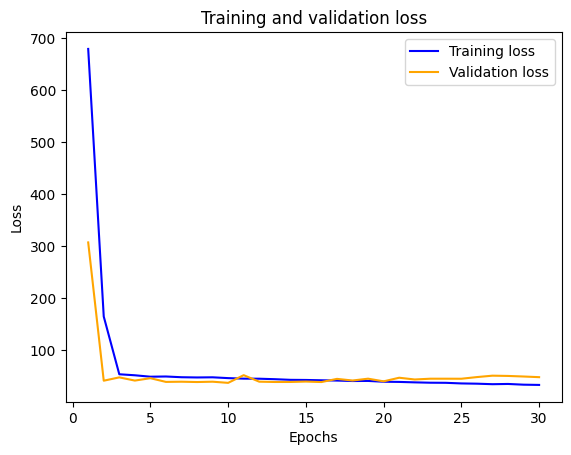

In [187]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [188]:
scores = model.evaluate(X_test, y_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y_pred = model.predict(X_test,verbose=1, batch_size=200)
y_true = y_test

66/66 [==============================] - 0s 4ms/step - loss: 22.1260 - RMSE: 2.0227 - PHME_score: 0.2489 - MAE: 2.0227

RMSE: 2.022660732269287

PHME: 0.24892345070838928

MAE: 2.022660732269287
66/66 [==============================] - 1s 3ms/step


410/410 [==============================] - 1s 3ms/step


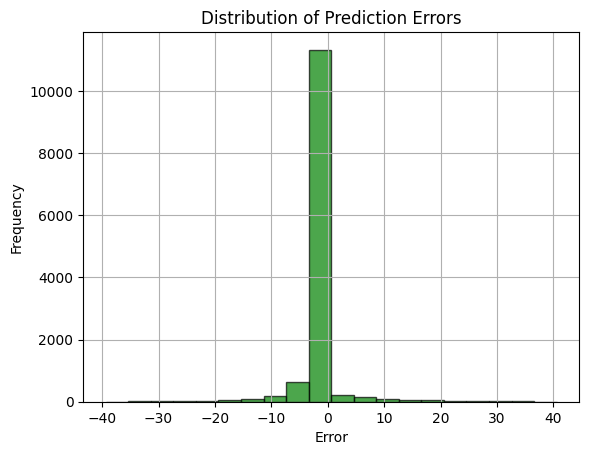

In [189]:
predictions = model.predict(X_test)
errors = predictions.flatten() - y_test
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [190]:
r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)

R-squared: 0.6482434244508104


In [191]:
engine_numbers = turbo1_test['ENr'].values
cycle_numbers = turbo1_test['C'].values

engine_cycle_array = np.column_stack((engine_numbers, cycle_numbers))

print(engine_cycle_array[:10])

[[101   1]
 [101   2]
 [101   3]
 [101   4]
 [101   5]
 [101   6]
 [101   7]
 [101   8]
 [101   9]
 [101  10]]


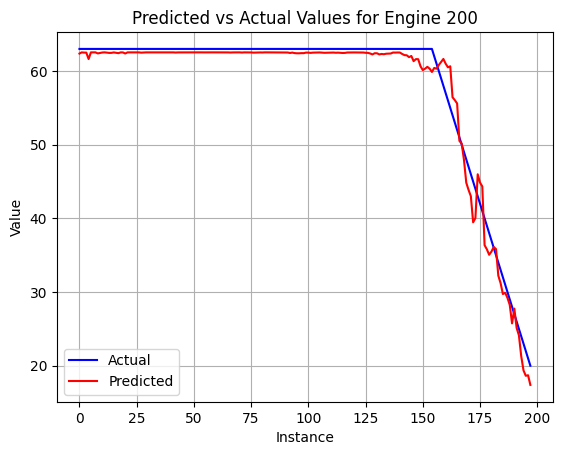

In [192]:
engine_number = 200

engine_indices = (engine_cycle_array[:, 0] == engine_number)
engine_actual_values = y_test[engine_indices].values
engine_predicted_values = predictions[engine_indices].flatten()

plt.plot(engine_actual_values, label='Actual', color='blue')
plt.plot(engine_predicted_values, label='Predicted', color='red')
plt.title(f'Predicted vs Actual Values for Engine {engine_number}')
plt.xlabel('Instance')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

##FD002

In [193]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X2_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 18, 64)            256       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 18, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 18, 64)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 32)            6176      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_10 (LSTM)              (None, 18, 100)          

In [194]:
history = model.fit(X2_train, y2_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
4301/4301 [==============================] - 44s 9ms/step - loss: 1428.3789 - RMSE: 29.8138 - PHME_score: 422.4931 - MAE: 29.8138 - val_loss: 620.0375 - val_RMSE: 17.1319 - val_PHME_score: 9.8923 - val_MAE: 17.1319
Epoch 2/30
4301/4301 [==============================] - 37s 9ms/step - loss: 589.4360 - RMSE: 17.8606 - PHME_score: 23.9233 - MAE: 17.8606 - val_loss: 631.6088 - val_RMSE: 17.1215 - val_PHME_score: 7.3693 - val_MAE: 17.1215
Epoch 3/30
4301/4301 [==============================] - 35s 8ms/step - loss: 497.4074 - RMSE: 16.3377 - PHME_score: 19.1446 - MAE: 16.3377 - val_loss: 415.1872 - val_RMSE: 14.0036 - val_PHME_score: 0.5648 - val_MAE: 14.0036
Epoch 4/30
4301/4301 [==============================] - 38s 9ms/step - loss: 318.3138 - RMSE: 13.1147 - PHME_score: 7.4977 - MAE: 13.1147 - val_loss: 295.6631 - val_RMSE: 11.1862 - val_PHME_score: 1.0487 - val_MAE: 11.1862
Epoch 5/30
4301/4301 [==============================] - 36s 8ms/step - loss: 294.5121 - RMSE: 12.5979 -

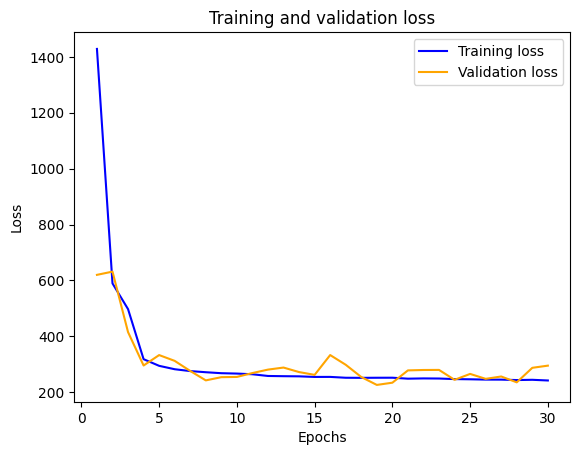

In [195]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [196]:
scores = model.evaluate(X2_test, y2_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y2_pred = model.predict(X2_test,verbose=1, batch_size=200)
y2_true = y2_test

170/170 [==============================] - 1s 4ms/step - loss: 345.8550 - RMSE: 8.5320 - PHME_score: 0.9389 - MAE: 8.5320

RMSE: 8.531987190246582

PHME: 0.9389188885688782

MAE: 8.531987190246582
170/170 [==============================] - 1s 4ms/step


1063/1063 [==============================] - 3s 3ms/step


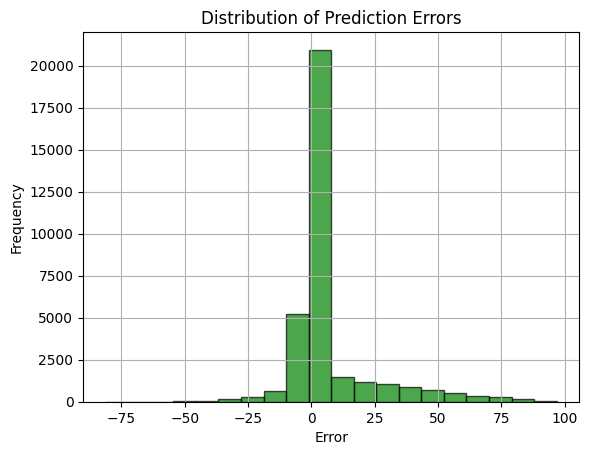

In [197]:
predictions = model.predict(X2_test)
errors = predictions.flatten() - y2_test
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [198]:
r_squared = r2_score(y2_test, predictions)
print("R-squared:", r_squared)

R-squared: 0.2647004881658802


In [199]:
engine_numbers = turbo2_test['ENr'].values
cycle_numbers = turbo2_test['C'].values

engine_cycle_array = np.column_stack((engine_numbers, cycle_numbers))

print(engine_cycle_array[:10])

[[261   1]
 [261   2]
 [261   3]
 [261   4]
 [261   5]
 [261   6]
 [261   7]
 [261   8]
 [261   9]
 [261  10]]


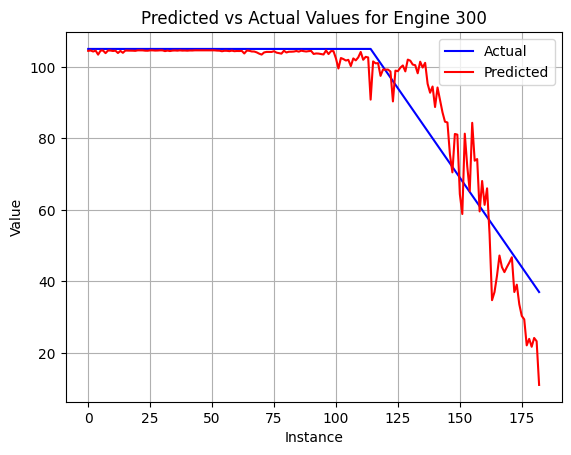

In [200]:
engine_number = 300

engine_indices = (engine_cycle_array[:, 0] == engine_number)
engine_actual_values = y2_test[engine_indices].values
engine_predicted_values = predictions[engine_indices].flatten()

plt.plot(engine_actual_values, label='Actual', color='blue')
plt.plot(engine_predicted_values, label='Predicted', color='red')
plt.title(f'Predicted vs Actual Values for Engine {engine_number}')
plt.xlabel('Instance')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

##FD003

In [201]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X3_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 20, 64)            256       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 20, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 20, 64)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 20, 32)            6176      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 20, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_12 (LSTM)              (None, 20, 100)          

In [202]:
history = model.fit(X3_train, y3_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
1978/1978 [==============================] - 22s 10ms/step - loss: 756.5164 - RMSE: 22.3508 - PHME_score: 29.6084 - MAE: 22.3508 - val_loss: 124.3623 - val_RMSE: 8.2430 - val_PHME_score: 2.6161 - val_MAE: 8.2430
Epoch 2/30
1978/1978 [==============================] - 18s 9ms/step - loss: 69.8062 - RMSE: 5.9076 - PHME_score: 0.5521 - MAE: 5.9076 - val_loss: 45.8392 - val_RMSE: 3.4658 - val_PHME_score: 0.6203 - val_MAE: 3.4658
Epoch 3/30
1978/1978 [==============================] - 17s 8ms/step - loss: 58.7607 - RMSE: 5.4850 - PHME_score: 0.4100 - MAE: 5.4850 - val_loss: 56.1305 - val_RMSE: 4.2744 - val_PHME_score: 0.8848 - val_MAE: 4.2744
Epoch 4/30
1978/1978 [==============================] - 17s 9ms/step - loss: 54.8330 - RMSE: 5.3280 - PHME_score: 0.3712 - MAE: 5.3280 - val_loss: 64.6517 - val_RMSE: 4.0241 - val_PHME_score: 1.0298 - val_MAE: 4.0241
Epoch 5/30
1978/1978 [==============================] - 18s 9ms/step - loss: 52.5668 - RMSE: 5.2196 - PHME_score: 0.3633 - MAE

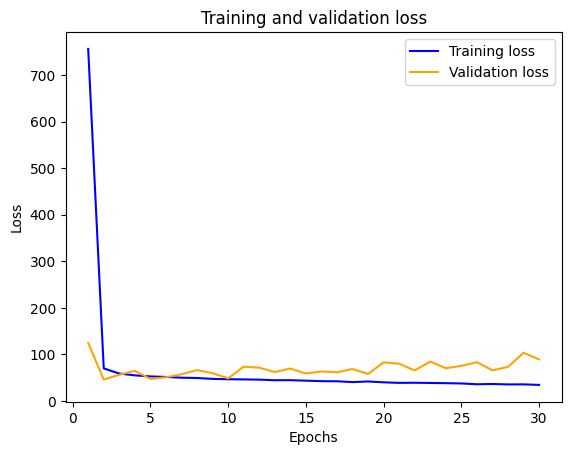

In [203]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [204]:
scores = model.evaluate(X3_test, y3_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y3_pred = model.predict(X3_test,verbose=1, batch_size=200)

83/83 [==============================] - 0s 5ms/step - loss: 29.1822 - RMSE: 2.0001 - PHME_score: 0.3469 - MAE: 2.0001

RMSE: 2.0000805854797363

PHME: 0.34692835807800293

MAE: 2.0000805854797363
83/83 [==============================] - 1s 3ms/step


519/519 [==============================] - 2s 3ms/step


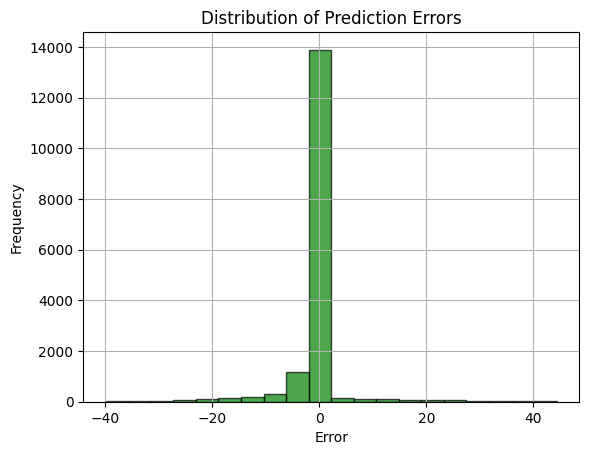

In [205]:
predictions = model.predict(X3_test)
errors = predictions.flatten() - y3_test
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [206]:
r_squared = r2_score(y3_test, predictions)
print("R-squared:", r_squared)

R-squared: 0.5218883731039892


In [207]:
engine_numbers = turbo3_test['ENr'].values
cycle_numbers = turbo3_test['C'].values

engine_cycle_array = np.column_stack((engine_numbers, cycle_numbers))

print(engine_cycle_array[:10])

[[101   1]
 [101   2]
 [101   3]
 [101   4]
 [101   5]
 [101   6]
 [101   7]
 [101   8]
 [101   9]
 [101  10]]


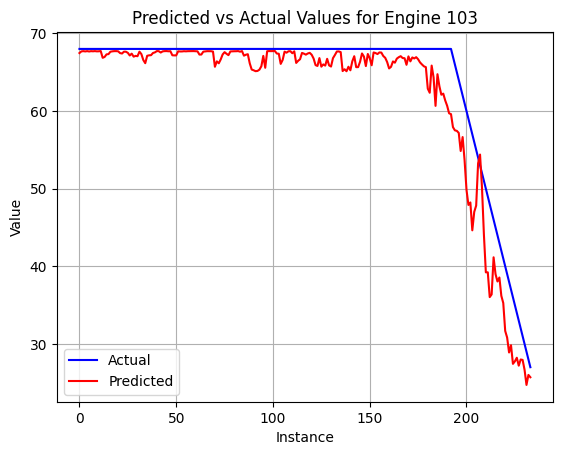

In [208]:
engine_number = 103

engine_indices = (engine_cycle_array[:, 0] == engine_number)
engine_actual_values = y3_test[engine_indices].values
engine_predicted_values = predictions[engine_indices].flatten()

plt.plot(engine_actual_values, label='Actual', color='blue')
plt.plot(engine_predicted_values, label='Predicted', color='red')
plt.title(f'Predicted vs Actual Values for Engine {engine_number}')
plt.xlabel('Instance')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

##FD004

In [209]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X4_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAE])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 18, 64)            256       
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 18, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 18, 64)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 18, 32)            6176      
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_14 (LSTM)              (None, 18, 100)          

In [210]:
history = model.fit(X4_train, y4_train, batch_size=10, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
4900/4900 [==============================] - 50s 9ms/step - loss: 1481.5677 - RMSE: 31.1766 - PHME_score: 365.1730 - MAE: 31.1766 - val_loss: 623.2709 - val_RMSE: 17.6739 - val_PHME_score: 7.7728 - val_MAE: 17.6739
Epoch 2/30
4900/4900 [==============================] - 45s 9ms/step - loss: 487.6666 - RMSE: 15.9970 - PHME_score: 14.0332 - MAE: 15.9970 - val_loss: 303.4311 - val_RMSE: 11.0214 - val_PHME_score: 1.6130 - val_MAE: 11.0214
Epoch 3/30
4900/4900 [==============================] - 44s 9ms/step - loss: 323.4207 - RMSE: 12.7979 - PHME_score: 11.6997 - MAE: 12.7979 - val_loss: 229.9763 - val_RMSE: 10.0302 - val_PHME_score: 5.8740 - val_MAE: 10.0302
Epoch 4/30
4900/4900 [==============================] - 43s 9ms/step - loss: 299.3936 - RMSE: 12.3200 - PHME_score: 11.2509 - MAE: 12.3200 - val_loss: 213.3333 - val_RMSE: 9.0430 - val_PHME_score: 1.3776 - val_MAE: 9.0430
Epoch 5/30
4900/4900 [==============================] - 42s 9ms/step - loss: 288.0661 - RMSE: 12.0090 - 

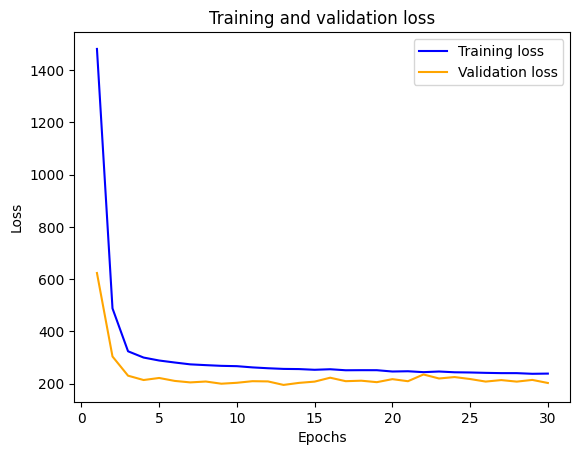

In [211]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [212]:
scores = model.evaluate(X4_test, y4_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAE: {}'.format(scores[3]))

y4_pred = model.predict(X4_test,verbose=1, batch_size=200)
y4_true = y4_test

207/207 [==============================] - 2s 6ms/step - loss: 159.5924 - RMSE: 7.1822 - PHME_score: 10.9620 - MAE: 7.1822

RMSE: 7.182196140289307

PHME: 10.962002754211426

MAE: 7.182196140289307
207/207 [==============================] - 1s 3ms/step


1288/1288 [==============================] - 4s 3ms/step


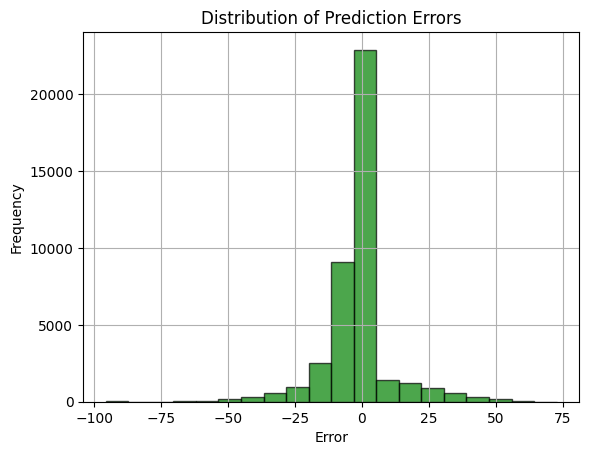

In [213]:
predictions = model.predict(X4_test)
errors = predictions.flatten() - y4_test
plt.hist(errors, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [214]:
r_squared = r2_score(y4_test, predictions)
print("R-squared:", r_squared)

R-squared: 0.5157692325275713


In [215]:
engine_numbers = turbo4_test['ENr'].values
cycle_numbers = turbo4_test['C'].values

engine_cycle_array = np.column_stack((engine_numbers, cycle_numbers))

print(engine_cycle_array[:10])

[[250   1]
 [250   2]
 [250   3]
 [250   4]
 [250   5]
 [250   6]
 [250   7]
 [250   8]
 [250   9]
 [250  10]]


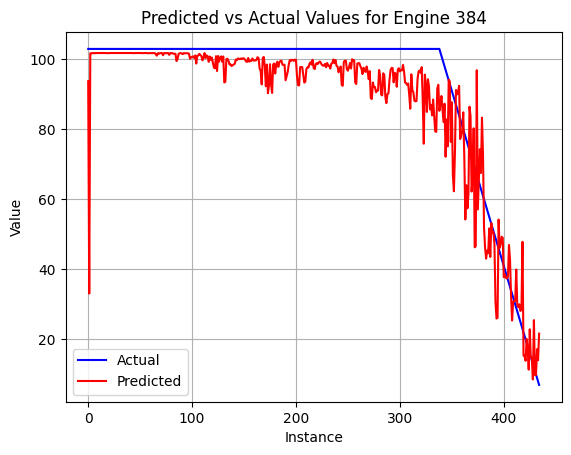

In [216]:
engine_number = 384

engine_indices = (engine_cycle_array[:, 0] == engine_number)
engine_actual_values = y4_test[engine_indices].values
engine_predicted_values = predictions[engine_indices].flatten()

plt.plot(engine_actual_values, label='Actual', color='blue')
plt.plot(engine_predicted_values, label='Predicted', color='red')
plt.title(f'Predicted vs Actual Values for Engine {engine_number}')
plt.xlabel('Instance')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()